In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
if not os.getcwd().endswith('CIoTS'):
    os.chdir('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CIoTS import *

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Helper: check if data exists

In [3]:
import os.path

def check_setups(setups, data_path):
    return not missing_setups(setups, data_path)

def missing_setups(setups, data_path):
    missing = []
    for dim, in_edges, tau, autocorr, _, run in setups:
        if not os.path.isfile(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle'):
            missing.append((dim, in_edges, tau, autocorr, run))
    return missing

# Execution

In [17]:
from itertools import product

dimensions = [5]
incoming_edges = [2,3]
taus = [5,10,15,20]
autocorrs = [True, False]
data_length = [10000]
runs = range(10)


setups = list(product(dimensions, incoming_edges, taus, autocorrs, data_length, runs))

## 1. Compute $F_1$ for known $\tau$

PC1 iterative vs. PC iterative

Also check for $\tau - k$ and $\tau + k$ to visualize importance of $\tau$ estimation

In [ ]:
import pickle

data_path = 'notebooks/ICML/icml_data/'
results_path = 'notebooks/ICML/icml_results/'
results = pd.DataFrame()
k = 2

algorithms = [(pc_incremental, 'PC incremental'),
              (pc_incremental_extensive, 'PC extensive'),
              (pc_incremental_pc1, 'PC1 incremental')]

if not check_setups(setups, data_path):
    print('Mising setups:')
    print(missing_setups(setups, data_path))

for dim, in_edges, tau, autocorr, _, run in setups:
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    
    df_dict = {'dimension': dim, 'max time lag': tau, 'incoming edges': in_edges, 'run': run, 'autocorr': autocorr}
    for algorithm, name in algorithms:
        _, graphs, _, _, _ = algorithm(partial_corr_test, generator.ts, max_p=tau+k, 
                               use_stopper=False, alpha=0.01, verbose=True)
        for offset in range(-k, k+1):
            f1_score = evaluate_edges(generator.graph, graphs[tau+offset])['f1-score']
            df_dict[name + '_f1' + (f'+{offset}' if offset>=0 else str(offset))] = f1_score

    results = results.append(df_dict, ignore_index=True)

results.to_csv(results_path + f'experiment1-Dim5.csv', index=False)

## 2. Compute estimate $\hat{\tau}$ for unknown $\tau$

Test VAR estimation vs. Incremental BIC (for $PC_1$) vs. Correltation test based

In [ ]:
import pickle

data_path = 'notebooks/ICML/icml_data/'
results_path = 'notebooks/ICML/icml_results/'
results = pd.DataFrame()

if not check_setups(setups, data_path):
    print('Mising setups:')
    print(missing_setups(setups, data_path))

for dim, in_edges, tau, autocorr, _, run in setups:
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    
    df_dict = {'dimension': dim, 'max time lag': tau, 'incoming edges': in_edges, 'run': run, 'autocorr': autocorr}
    algorithms = [
        (pc_incremental_pc1, {
            'indep_test': partial_corr_test,
            'ts': generator.ts,
            'max_p': 2*tau,
            'stopper': ICStopper(dim, patiency=2, ic='bic'),
            'verbose': True}, lambda r: r[3].best_tau, 'PC1 incremental: BIC'),
        (pc_incremental_pc1, {
            'indep_test': partial_corr_test,
            'ts': generator.ts,
            'max_p': 2*tau,
            'stopper': CorrStopper(dim, patiency=1, max_tau=2*tau),
            'verbose': True}, lambda r: r[3].best_tau, 'PC1 incremental: Correlation'),
        (var_order_select, {
            'ts': generator.ts, 
            'max_p': 2*tau, 
            'ics': ['bic']}, lambda r: r[0]['bic'][0], 'VAR: BIC'),
        (pc_incremental, {
            'indep_test': partial_corr_test,
            'ts': generator.ts,
            'max_p': 2*tau,
            'stopper': ICStopper(dim, patiency=2, ic='bic'),
            'verbose': True}, lambda r: r[3].best_tau, 'PC incremental: BIC'),
        (pc_incremental_extensive, {
            'indep_test': partial_corr_test,
            'ts': generator.ts,
            'max_p': 2*tau,
            'stopper': ICStopper(dim, patiency=2, ic='bic'),
            'verbose': True}, lambda r: r[3].best_tau, 'PC extensive: BIC')
    ]
    for algorithm, params, result_func, name in algorithms:
        result = algorithm(**params)
        df_dict[name + '_tau'] = result_func(result)
    results = results.append(df_dict, ignore_index=True)

results.to_csv(results_path + f'experiment2-Dim5.csv', index=False)

## 3. Evaluate each iteration

In [ ]:
import pickle

data_path = 'notebooks/ICML/icml_data/'
results_path = 'notebooks/ICML/icml_results/'
results = pd.DataFrame()

algorithms = [(pc_incremental, 'PC incremental'),
              (pc_incremental_extensive, 'PC extensive'),
              (pc_incremental_pc1, 'PC1 incremental')]

if not check_setups(setups, data_path):
    print('Mising setups:')
    print(missing_setups(setups, data_path))   
    
for dim, in_edges, tau, autocorr, _, run in setups:
    generator = pickle.load(open(data_path + f't={tau}_d={dim}_in={in_edges}_autocorr={autocorr}_{run}.pickle', 'rb'))
    max_tau = 2 * tau
    
    df_dict = {'dimension': [dim]*max_tau, 'max time lag': [tau]*max_tau, 'incoming edges': [in_edges]*max_tau, 
               'run': [run]*max_tau, 'autocorr': [autocorr]*max_tau, 'tau estimate': list(range(1, max_tau+1))}
    
    for algorithm, name in algorithms:
        _, graphs, _, stopper, _ = algorithm(partial_corr_test, generator.ts, max_p=max_tau, 
                                             use_stopper=False, alpha=0.01, verbose=True)

        confusion, confusion_delta = evaluate_edge_deletion(generator.graph,
                                                            [{'graph': graphs[t], 'p_iter': t} 
                                                             for t in range(1, max_tau+1)],
                                                            dim)
        added_edges = (confusion_delta['tp'] + confusion_delta['fp']).tolist()
        f1_scores = [evaluate_edges(generator.graph, graphs[t])['f1-score'] for t in range(1, max_tau+1)]
        bics = [stopper.scores()[t] for t in range(1, max_tau+1)]
        
        eval_dict = {name + '_tn': confusion['tn'].tolist(), name + '_fp': confusion['fp'].tolist(),
                     name + '_tp': confusion['tp'].tolist(), name + '_fn': confusion['fn'].tolist(),
                     name + '_f1': f1_scores, name + '_bics': bics, name + '_added_edges': added_edges}
        df_dict.update(eval_dict)
        
    df = pd.DataFrame(df_dict)
    results = results.append(df, ignore_index=True)

results.to_csv(results_path + f'experiment3-Dim5.csv', index=False)

In [16]:
results.shape

(20, 10)

# Visualization

## 1. Visualize $F_1$ for known $\tau$

In [25]:
from functools import reduce
import sys
eps = sys.float_info.epsilon

def plot_f1_groupedbarchart(df_dict, title):
    assert len(df_dict) > 0
    #assert reduce(lambda x,y: np.all(x == y), map(lambda e:e.columns, grouped_result.values()))
    bar_labels = [f'$\\tau + {c[1]}$' if c[1]>=0 else f'$\\tau - {abs(c[1])}$'
                  for c in next(iter(grouped_result.values())).columns]
    
    fig, ax = plt.subplots(figsize=(20,10))
    ind = np.arange(len(bar_labels))
    width = 0.7 / len(df_dict)
    
    plots = []
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for w_idx, (algo, f1s) in enumerate(df_dict.items()):
        p = ax.bar(ind + w_idx*width + (width / 2), np.mean(f1s, axis=0), width, 
                   color=color_cycle[w_idx % len(color_cycle)],
                   bottom=0, yerr=np.std(f1s, axis=0))
        plots.append(p[0])

    ax.set_title(title)
    ax.set_xticks(ind + (len(df_dict) * width) / 2)
    ax.set_xticklabels(bar_labels)

    ax.legend(plots, df_dict.keys())
    ax.autoscale_view()

    plt.show()

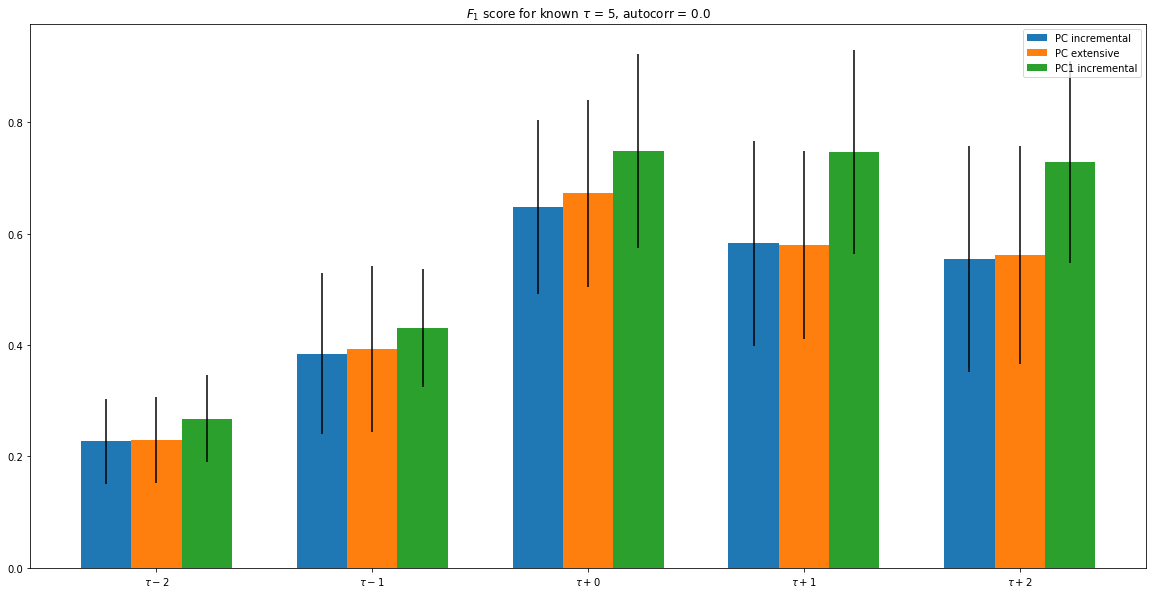

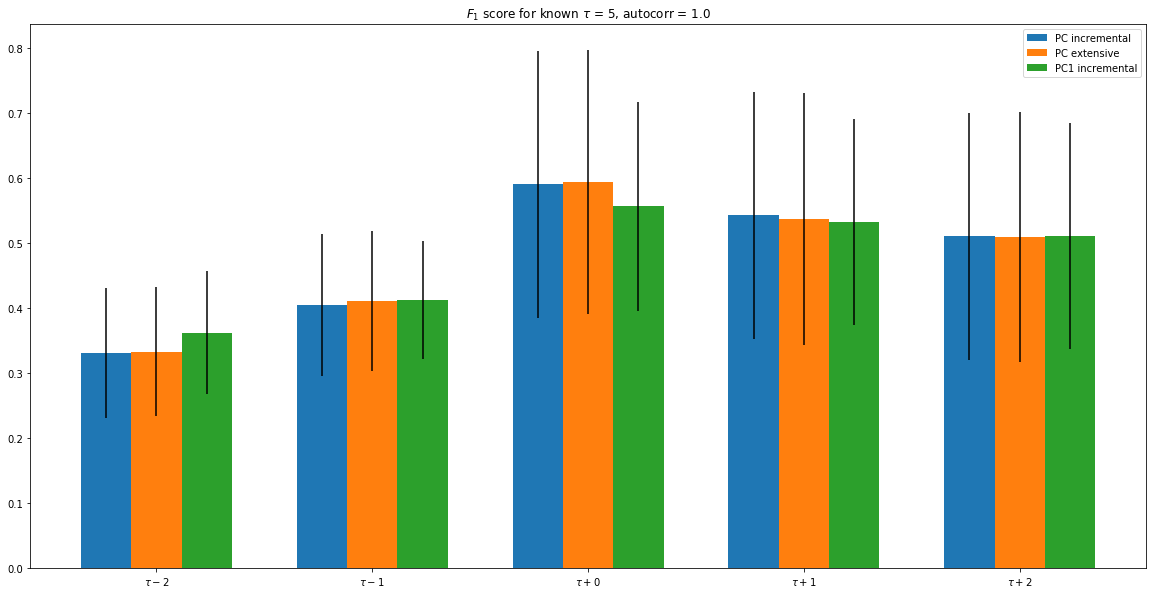

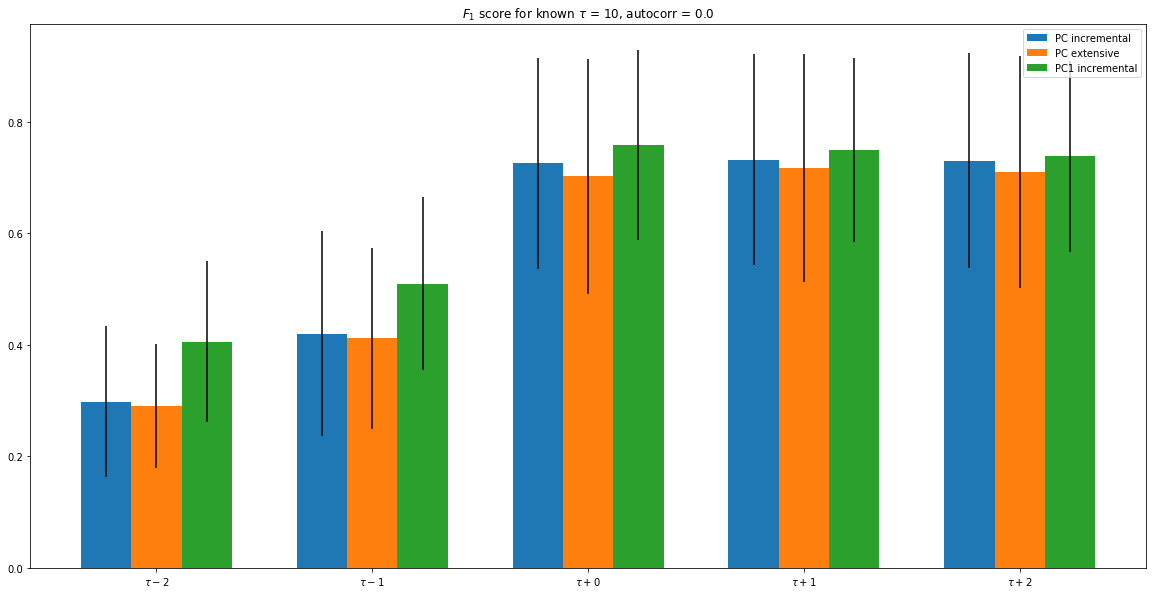

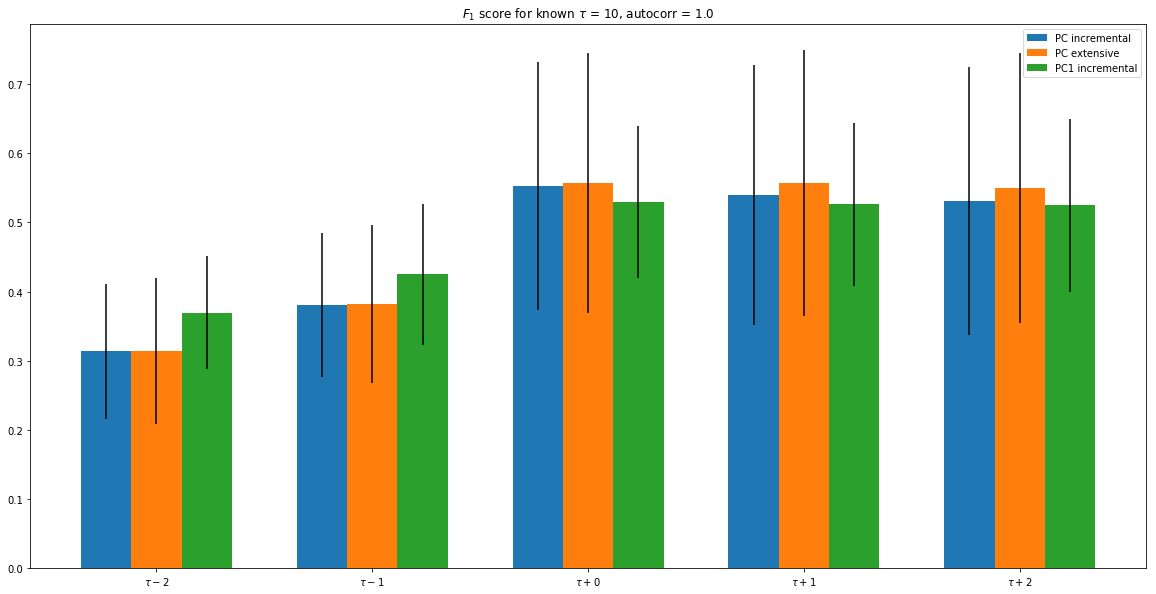

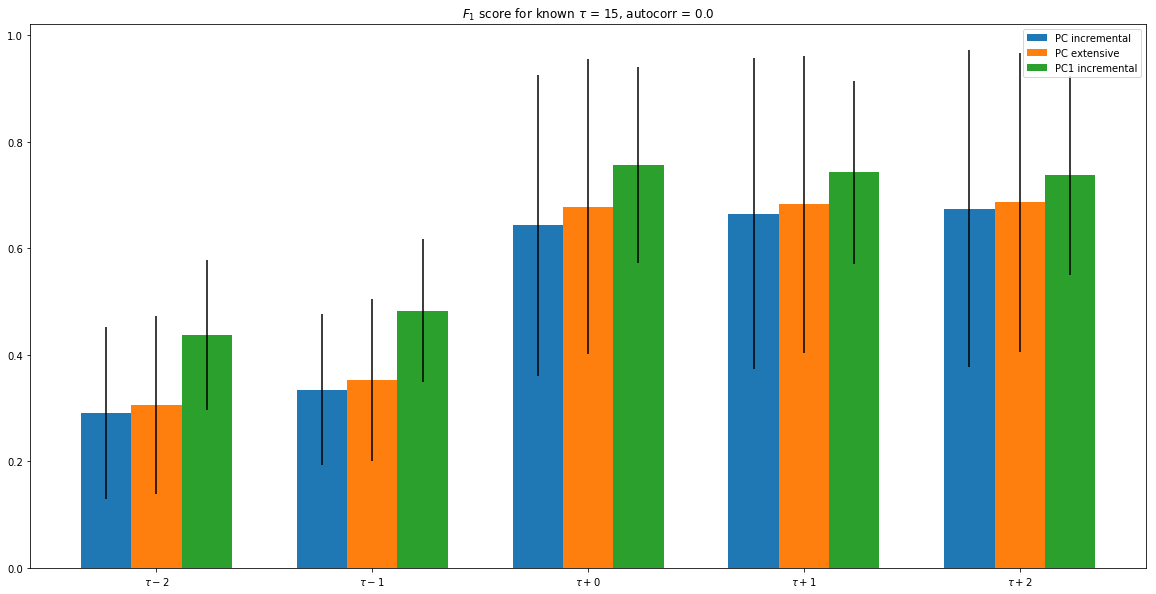

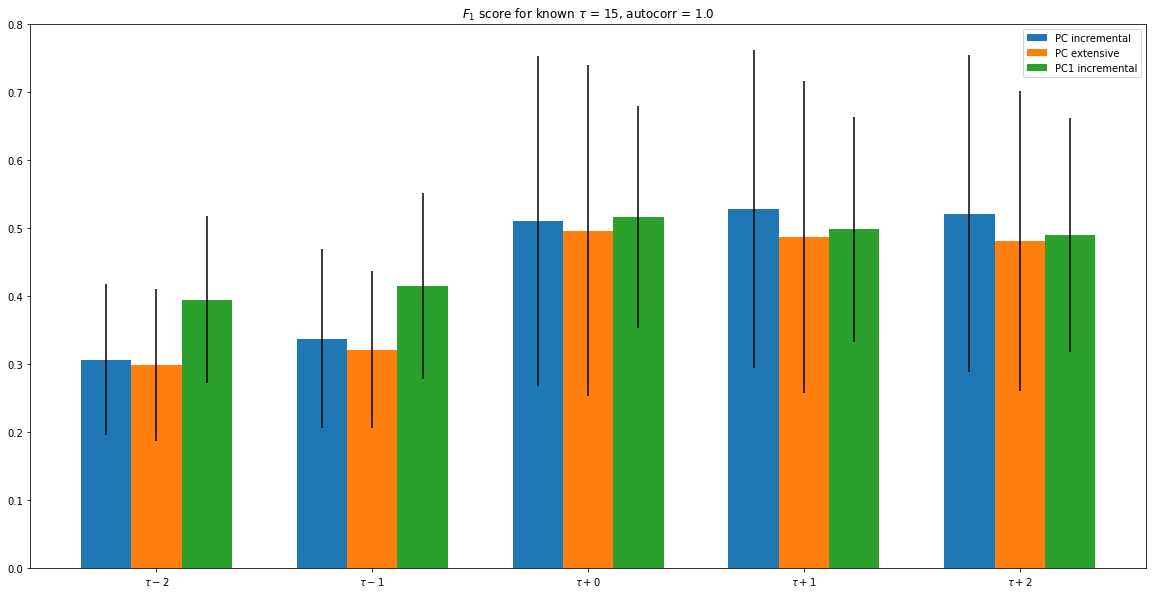

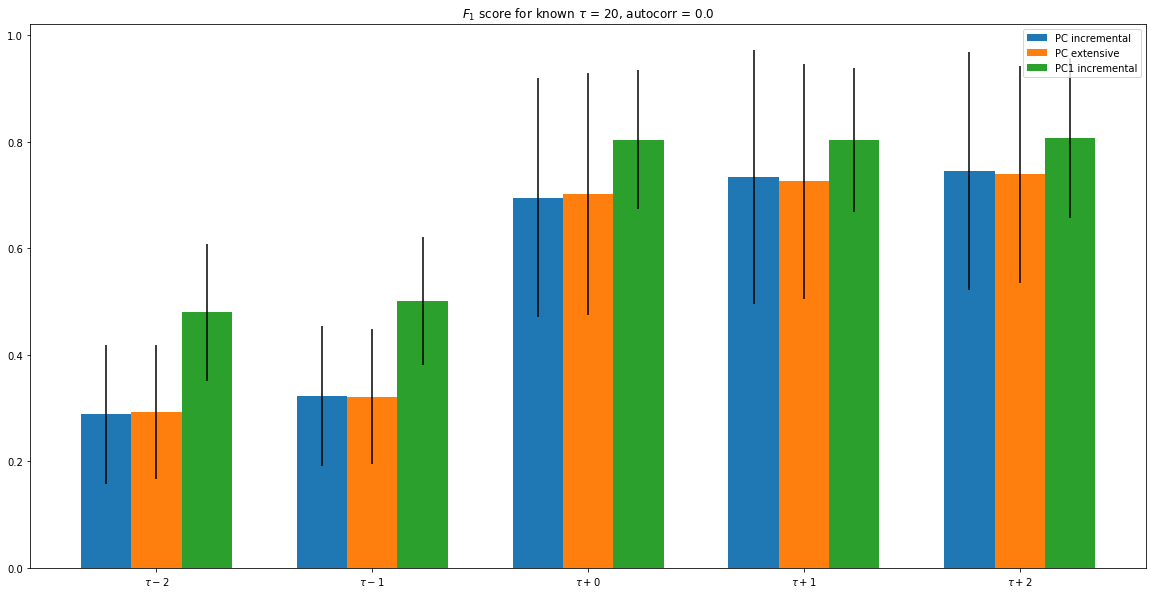

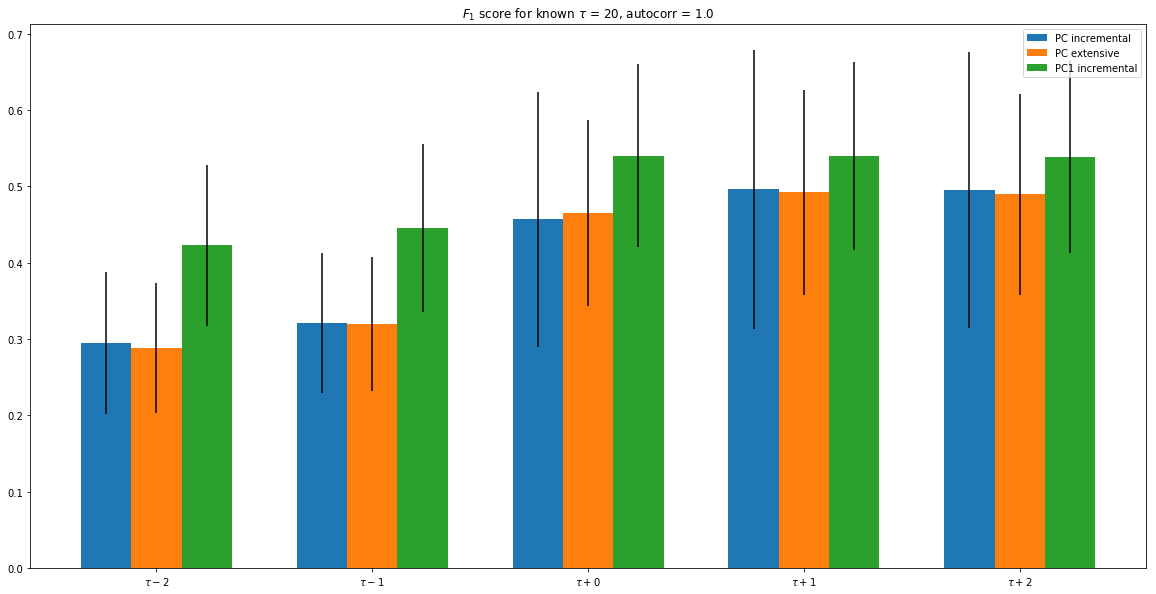

In [8]:
results_path = 'notebooks/ICML/icml_results/'
algorithms = [(pc_incremental, 'PC incremental'),
              (pc_incremental_extensive, 'PC extensive'),
              (pc_incremental_pc1, 'PC1 incremental')]

results = pd.read_csv(results_path + 'experiment1-Dim5.csv')
for group, result in results.groupby(['max time lag', 'autocorr']): # Group by ['dimension', 'incoming edges', 'autocorr'] as well?
    tau = int(group[0])
    autocorr = float(group[1])
    grouped_result = {}
    for algorithm, name in algorithms:
        algo_cols = [col for col in result.columns if col[:col.rfind('_')] == name]
        df = result[algo_cols].rename(lambda c:('f1', int(c.split('_')[-1][2:])), axis='columns')
        grouped_result[name] = df[sorted(df.columns)]
    plot_f1_groupedbarchart(grouped_result, title=f'$F_1$ score for known $\\tau$ = {tau}, autocorr = {autocorr}')

## 2. Visualize estimate $\hat{\tau}$ for unknown $\tau$

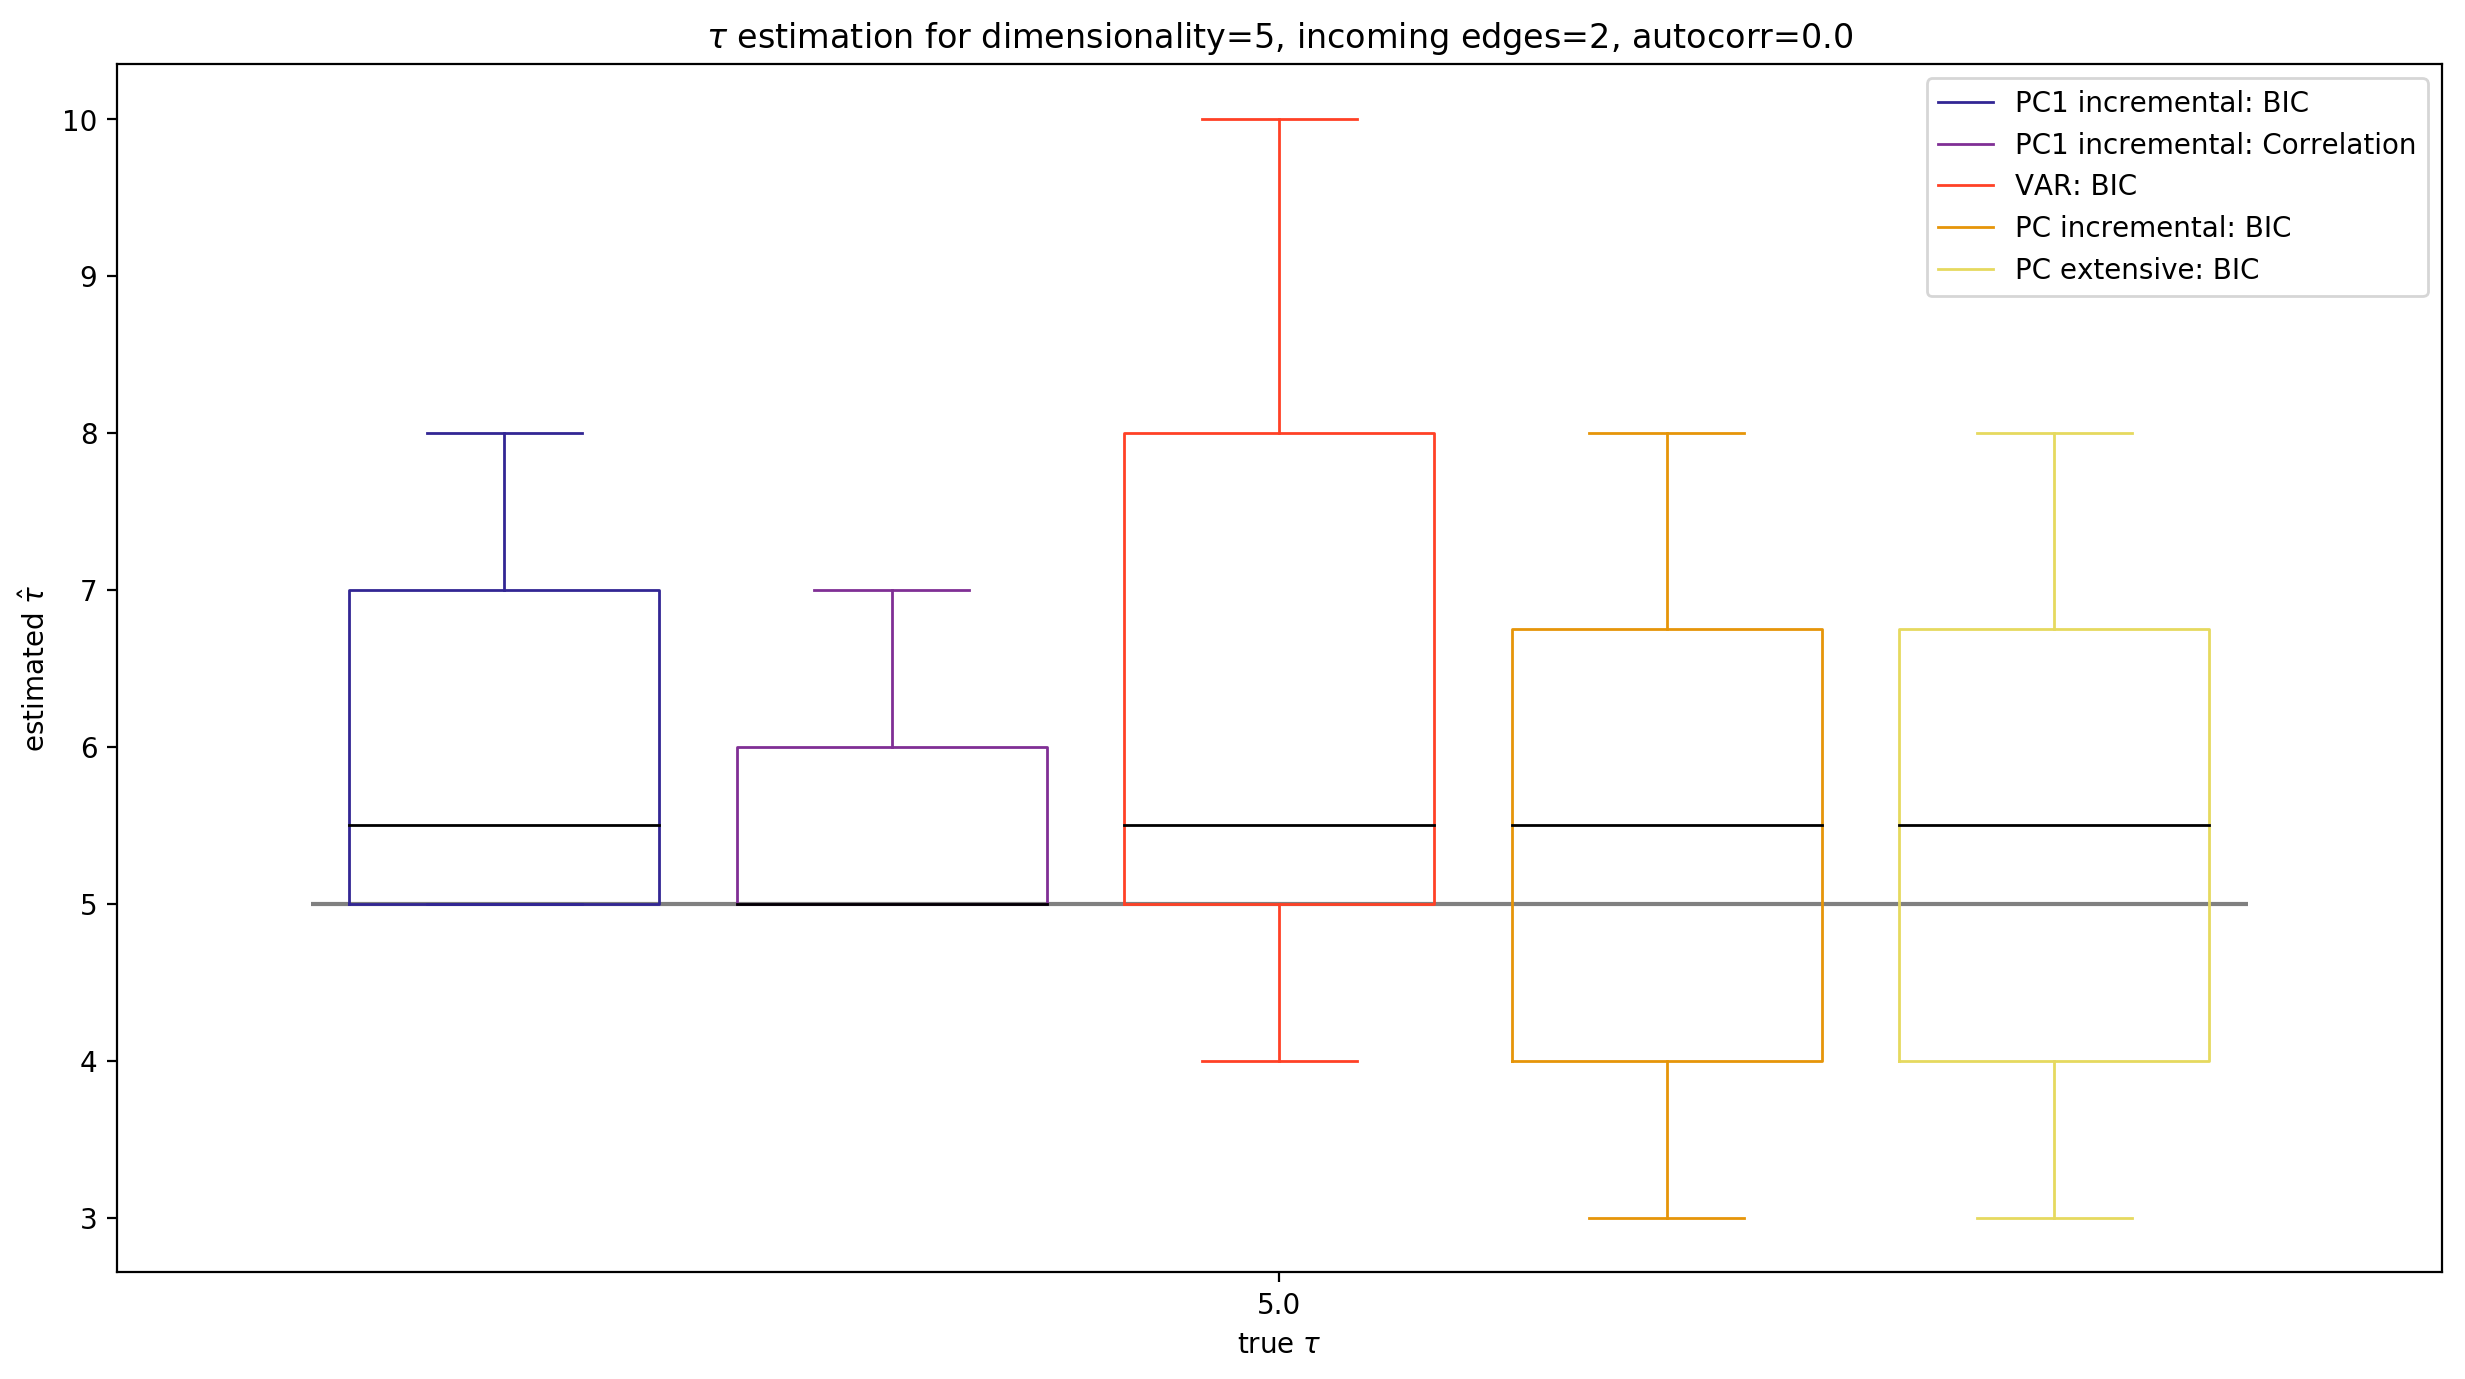

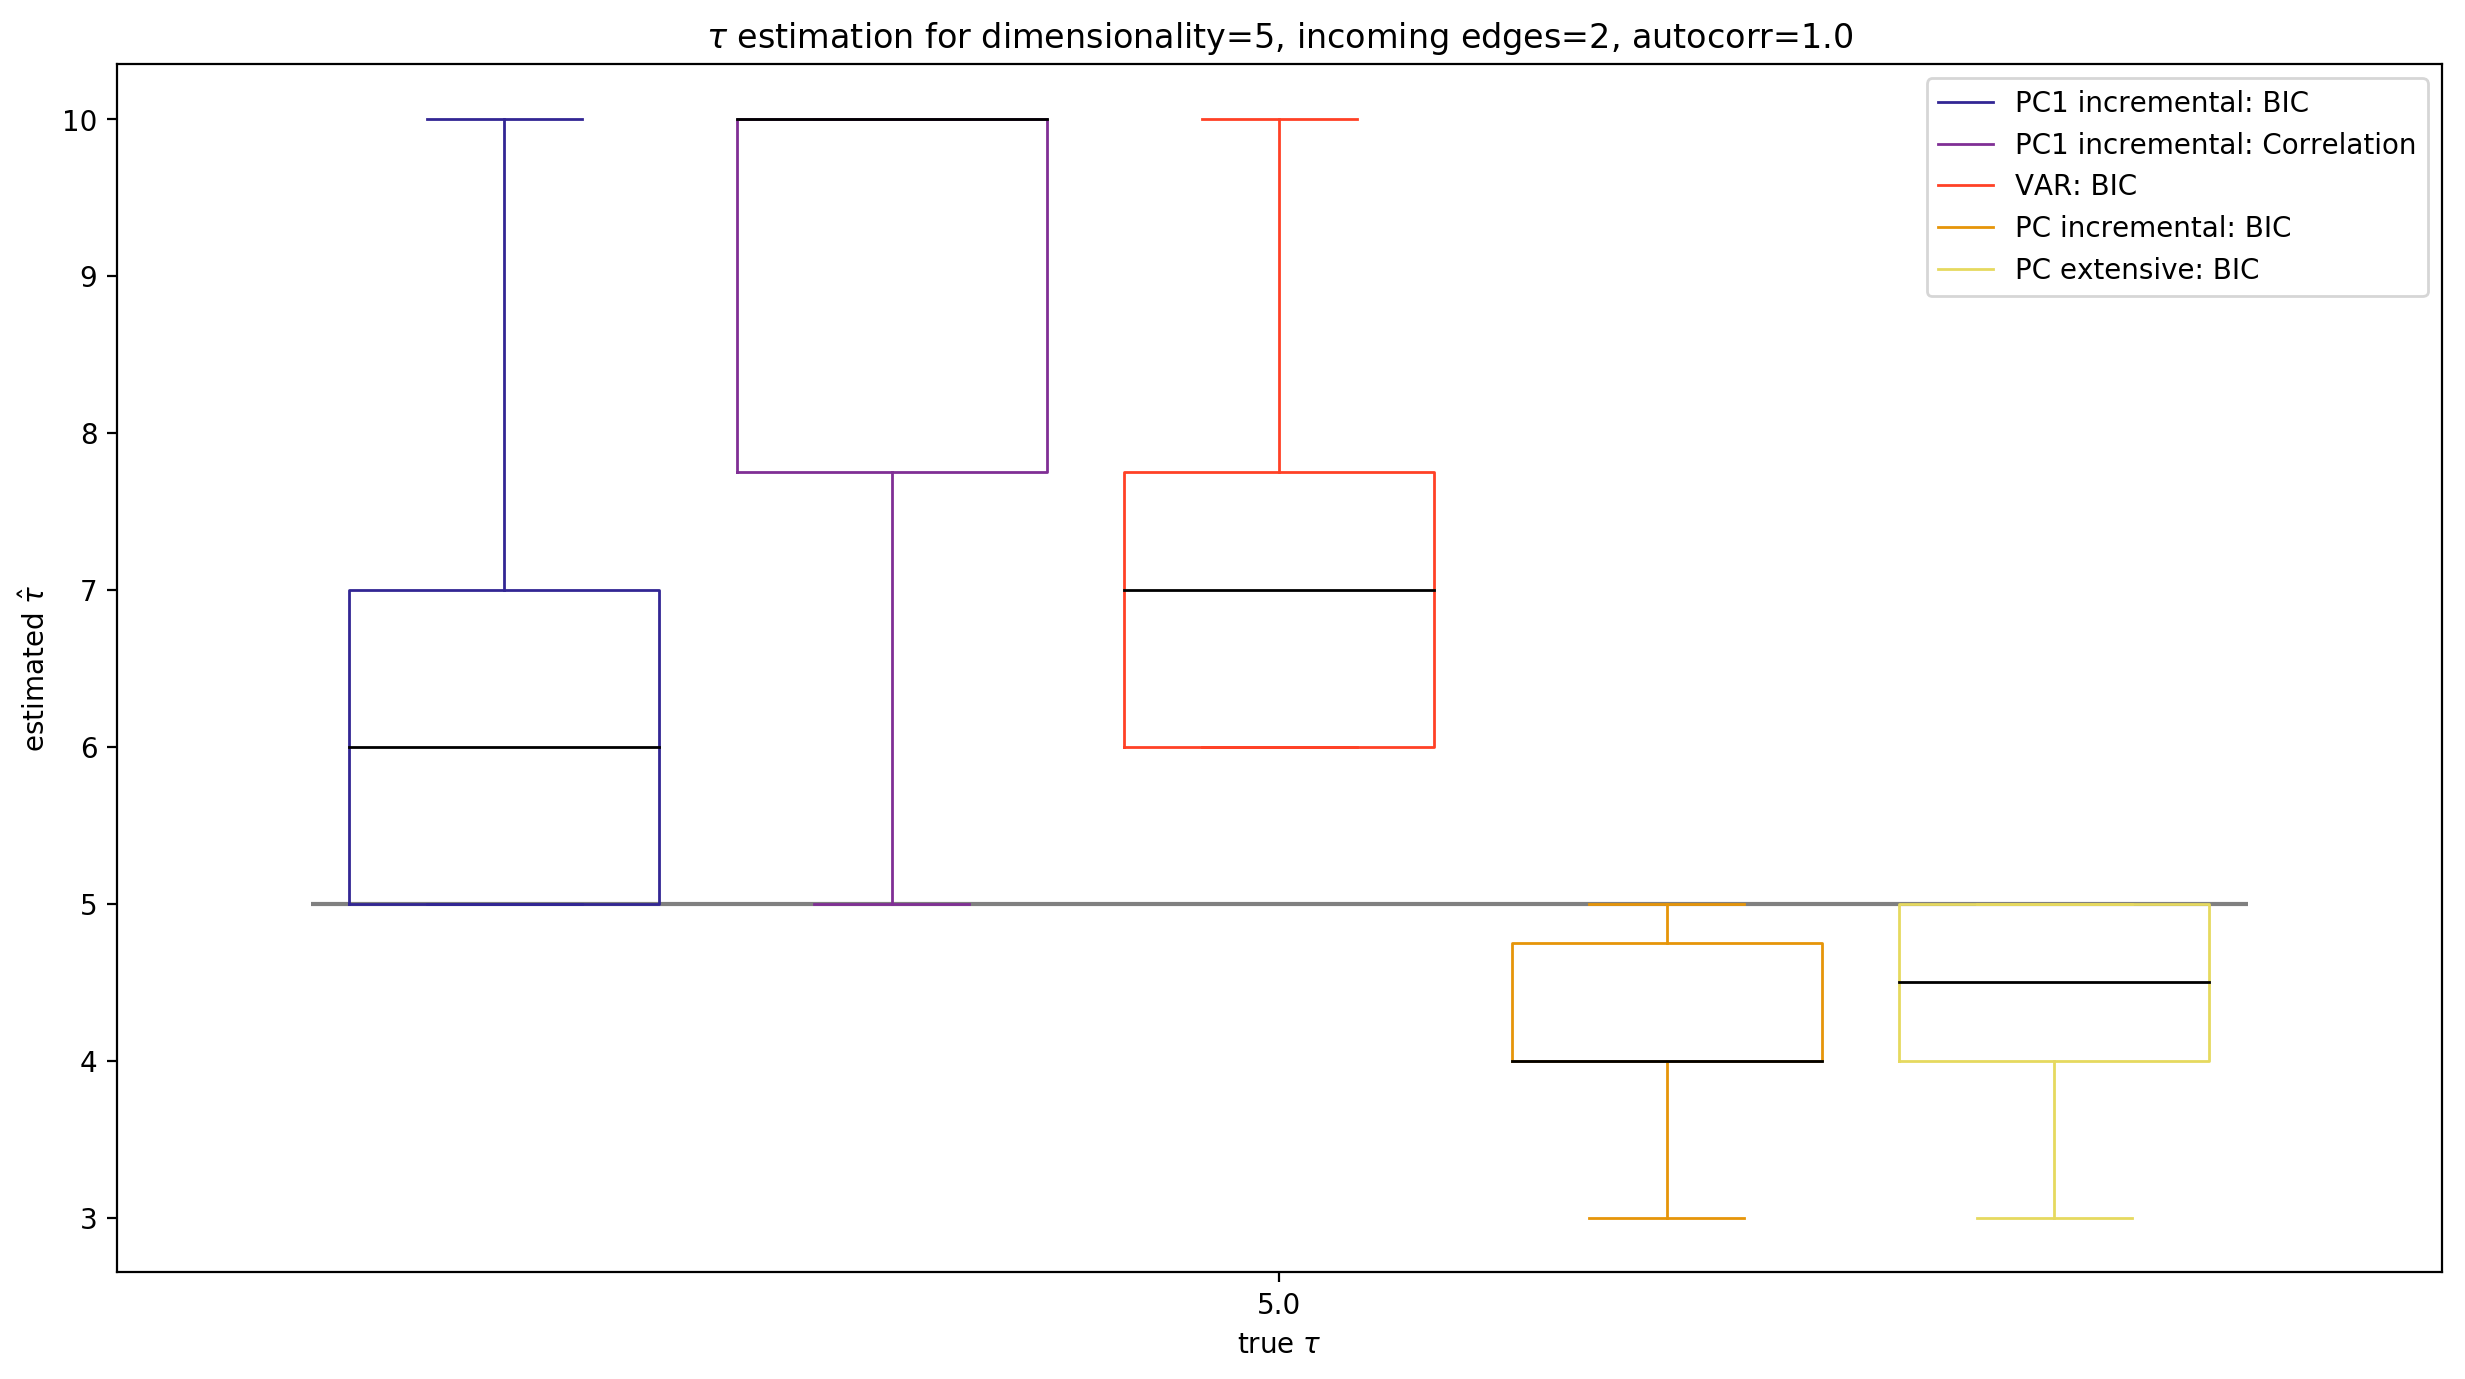

In [23]:
from math import floor

visualize = [(5, 2, False), (5, 3, False), (5, 2, True), (5, 3, True)]
names = ['PC1 incremental: BIC', 'PC1 incremental: Correlation',
         'VAR: BIC', 'PC incremental: BIC', 'PC extensive: BIC']

width = 0.4
results_path = 'notebooks/ICML/icml_results/'
cols = [name + '_tau' for name in names]

results = pd.read_csv(results_path + 'experiment2-Dim5.csv')
true_taus = np.unique(results['max time lag'])

for group, result in results.groupby(['dimension', 'incoming edges', 'autocorr']): 
    
    if group not in visualize:
        continue
    
    dim = int(group[0])
    in_edges = int(group[1])
    autocorr = float(group[2])
    
    colors = plt.cm.CMRmap(np.linspace(0,1,len(names)+2))
    plt.figure(dpi=200, figsize=(15, 8))
    
    
    for tau in true_taus:
        start_x = tau - (width+0.1)*(len(names))/2
        end_x = tau + (width+0.1)*(len(names))/2
        y = tau
        plt.hlines(y, start_x, end_x, colors='grey')
    
    bps = []
    for i, name in enumerate(names):
        positions = [tau + (width+0.1)*(i - (len(names)-1)/2) for tau in true_taus]
        arr = [result.loc[result['max time lag']==tau, cols[i]] for tau in true_taus]
        bp = plt.boxplot(arr, positions=positions, widths=width, showfliers=False,
                         whiskerprops={'color': colors[i+1]}, boxprops={'color': colors[i+1]},
                         capprops={'color': colors[i+1]}, medianprops={'color': 'black'})
        bps.append(bp)
    
    plt.xlabel('true $\\tau$')
    plt.ylabel('estimated $\\hat{\\tau}$')
    plt.xticks(true_taus, true_taus)
    plt.title(f'$\\tau$ estimation for dimensionality={dim}, incoming edges={in_edges}, autocorr={autocorr}')
    plt.xlim(min(true_taus)-(width+0.2)*len(names)/2, max(true_taus)+(width+0.2)*len(names)/2)
    
    plt.legend([bps[i]['whiskers'][0] for i in range(len(names))], names)
    plt.show()

## 3. Visualize iterations

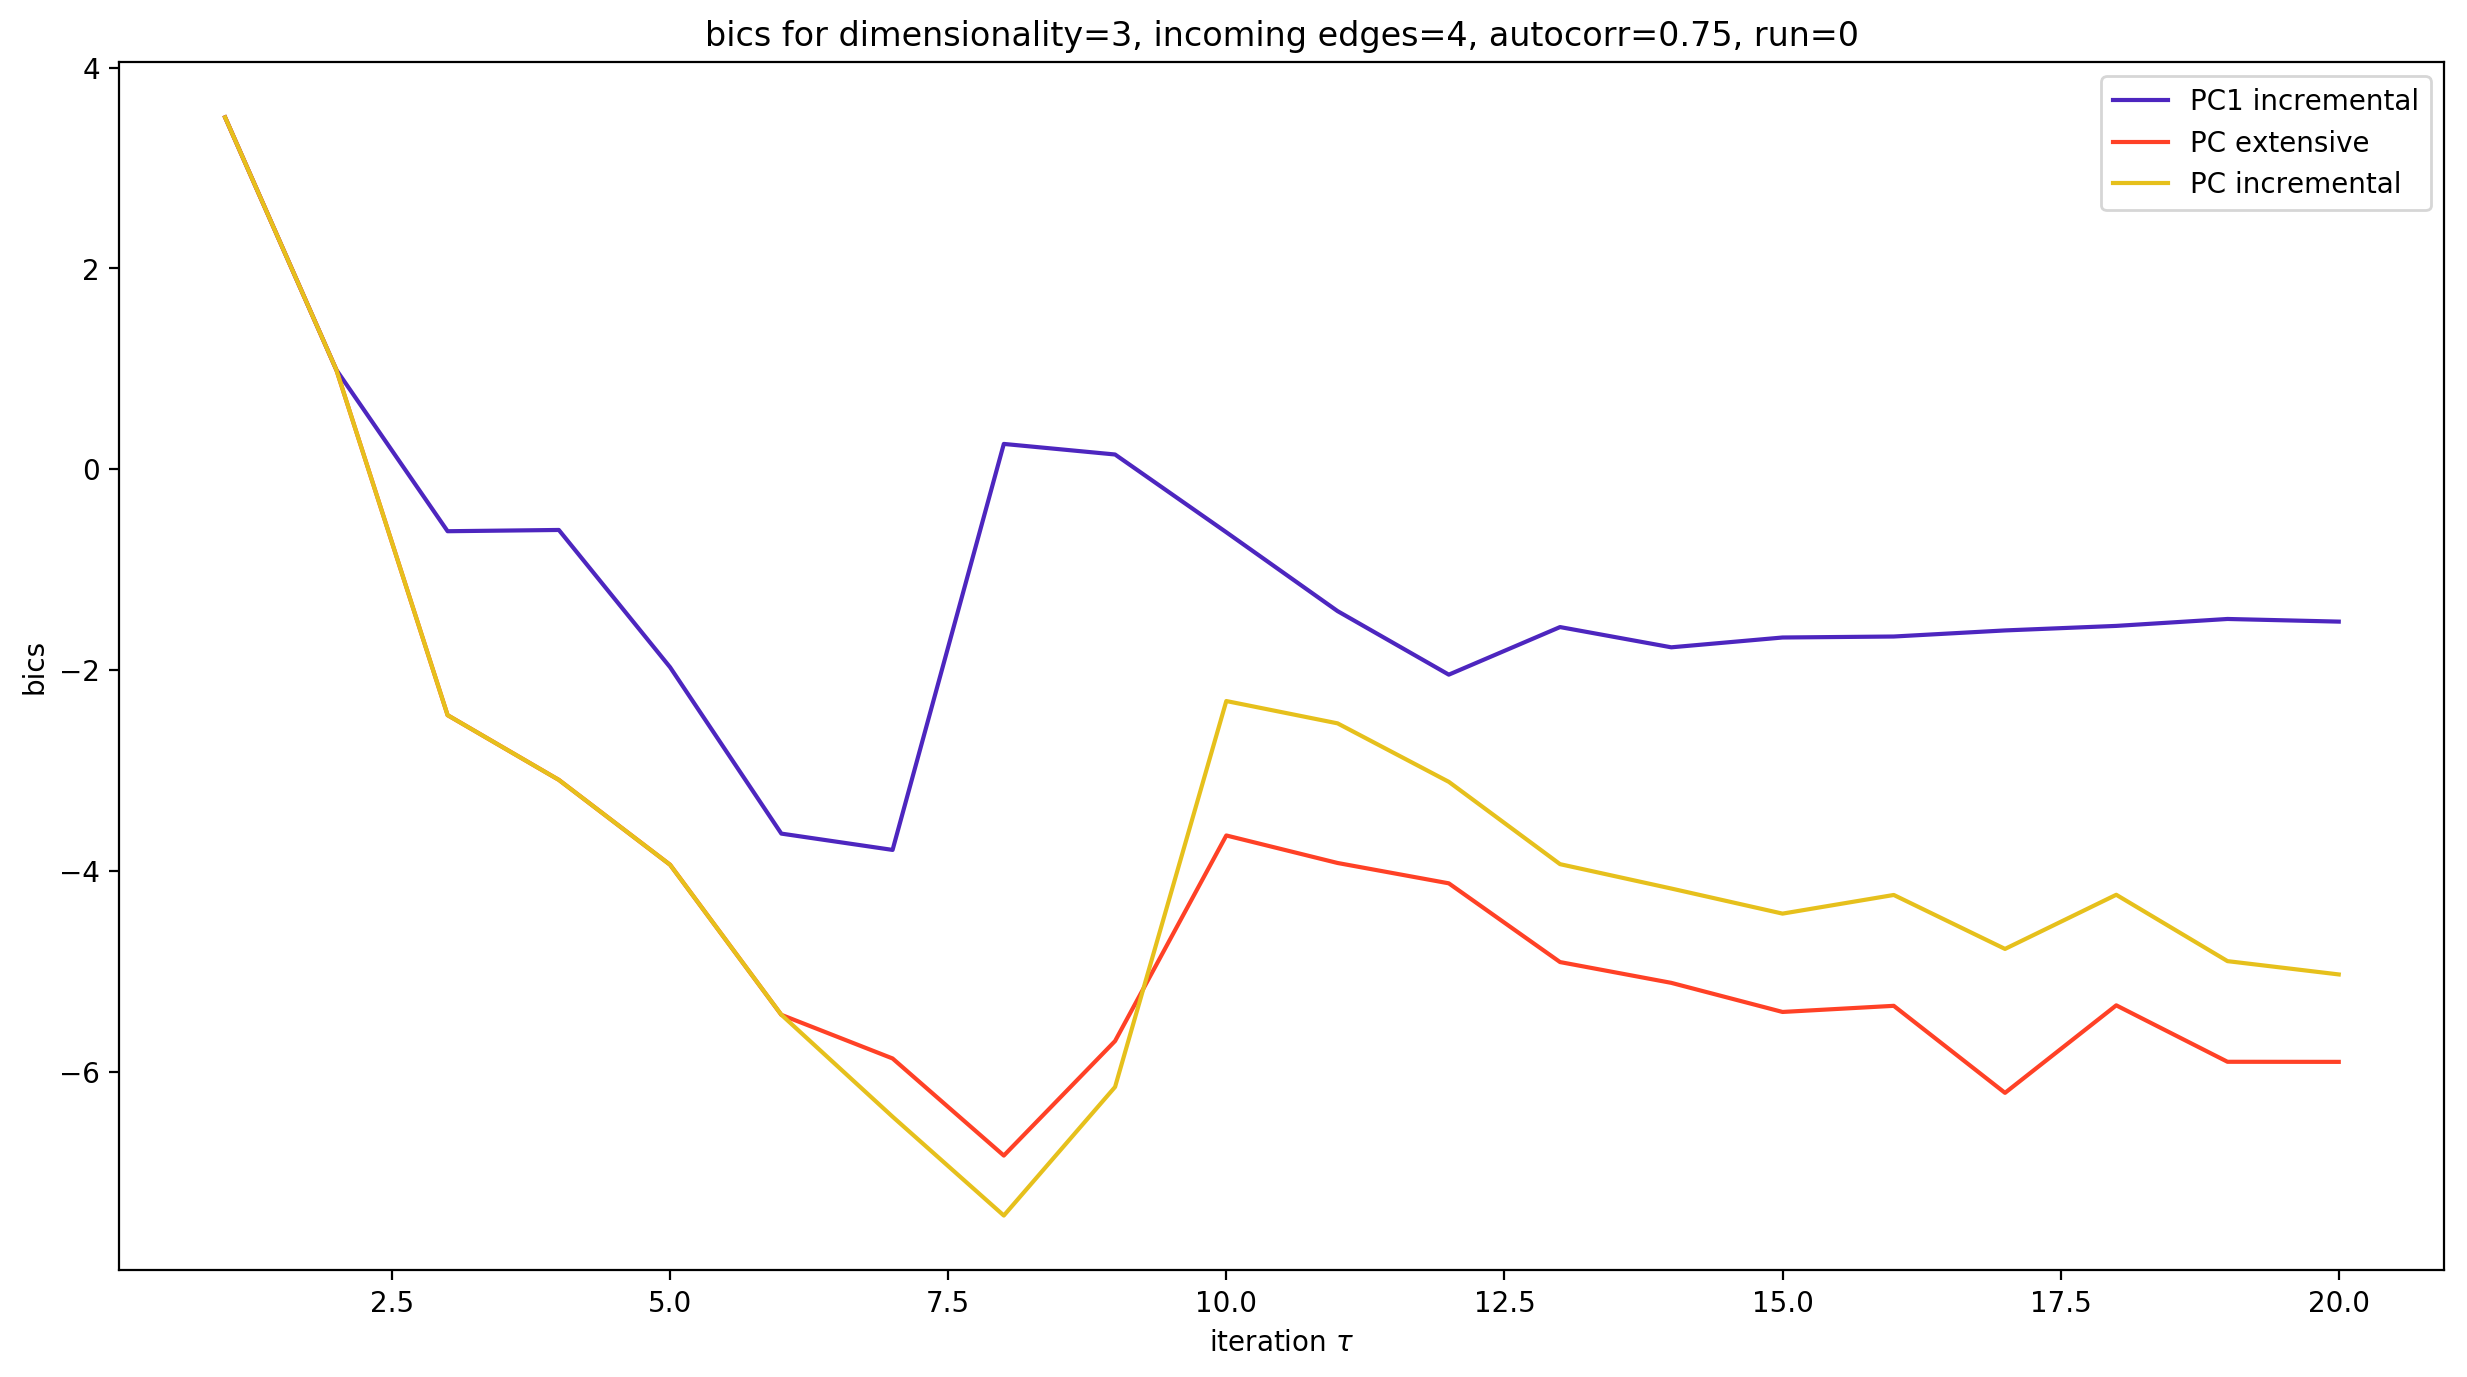

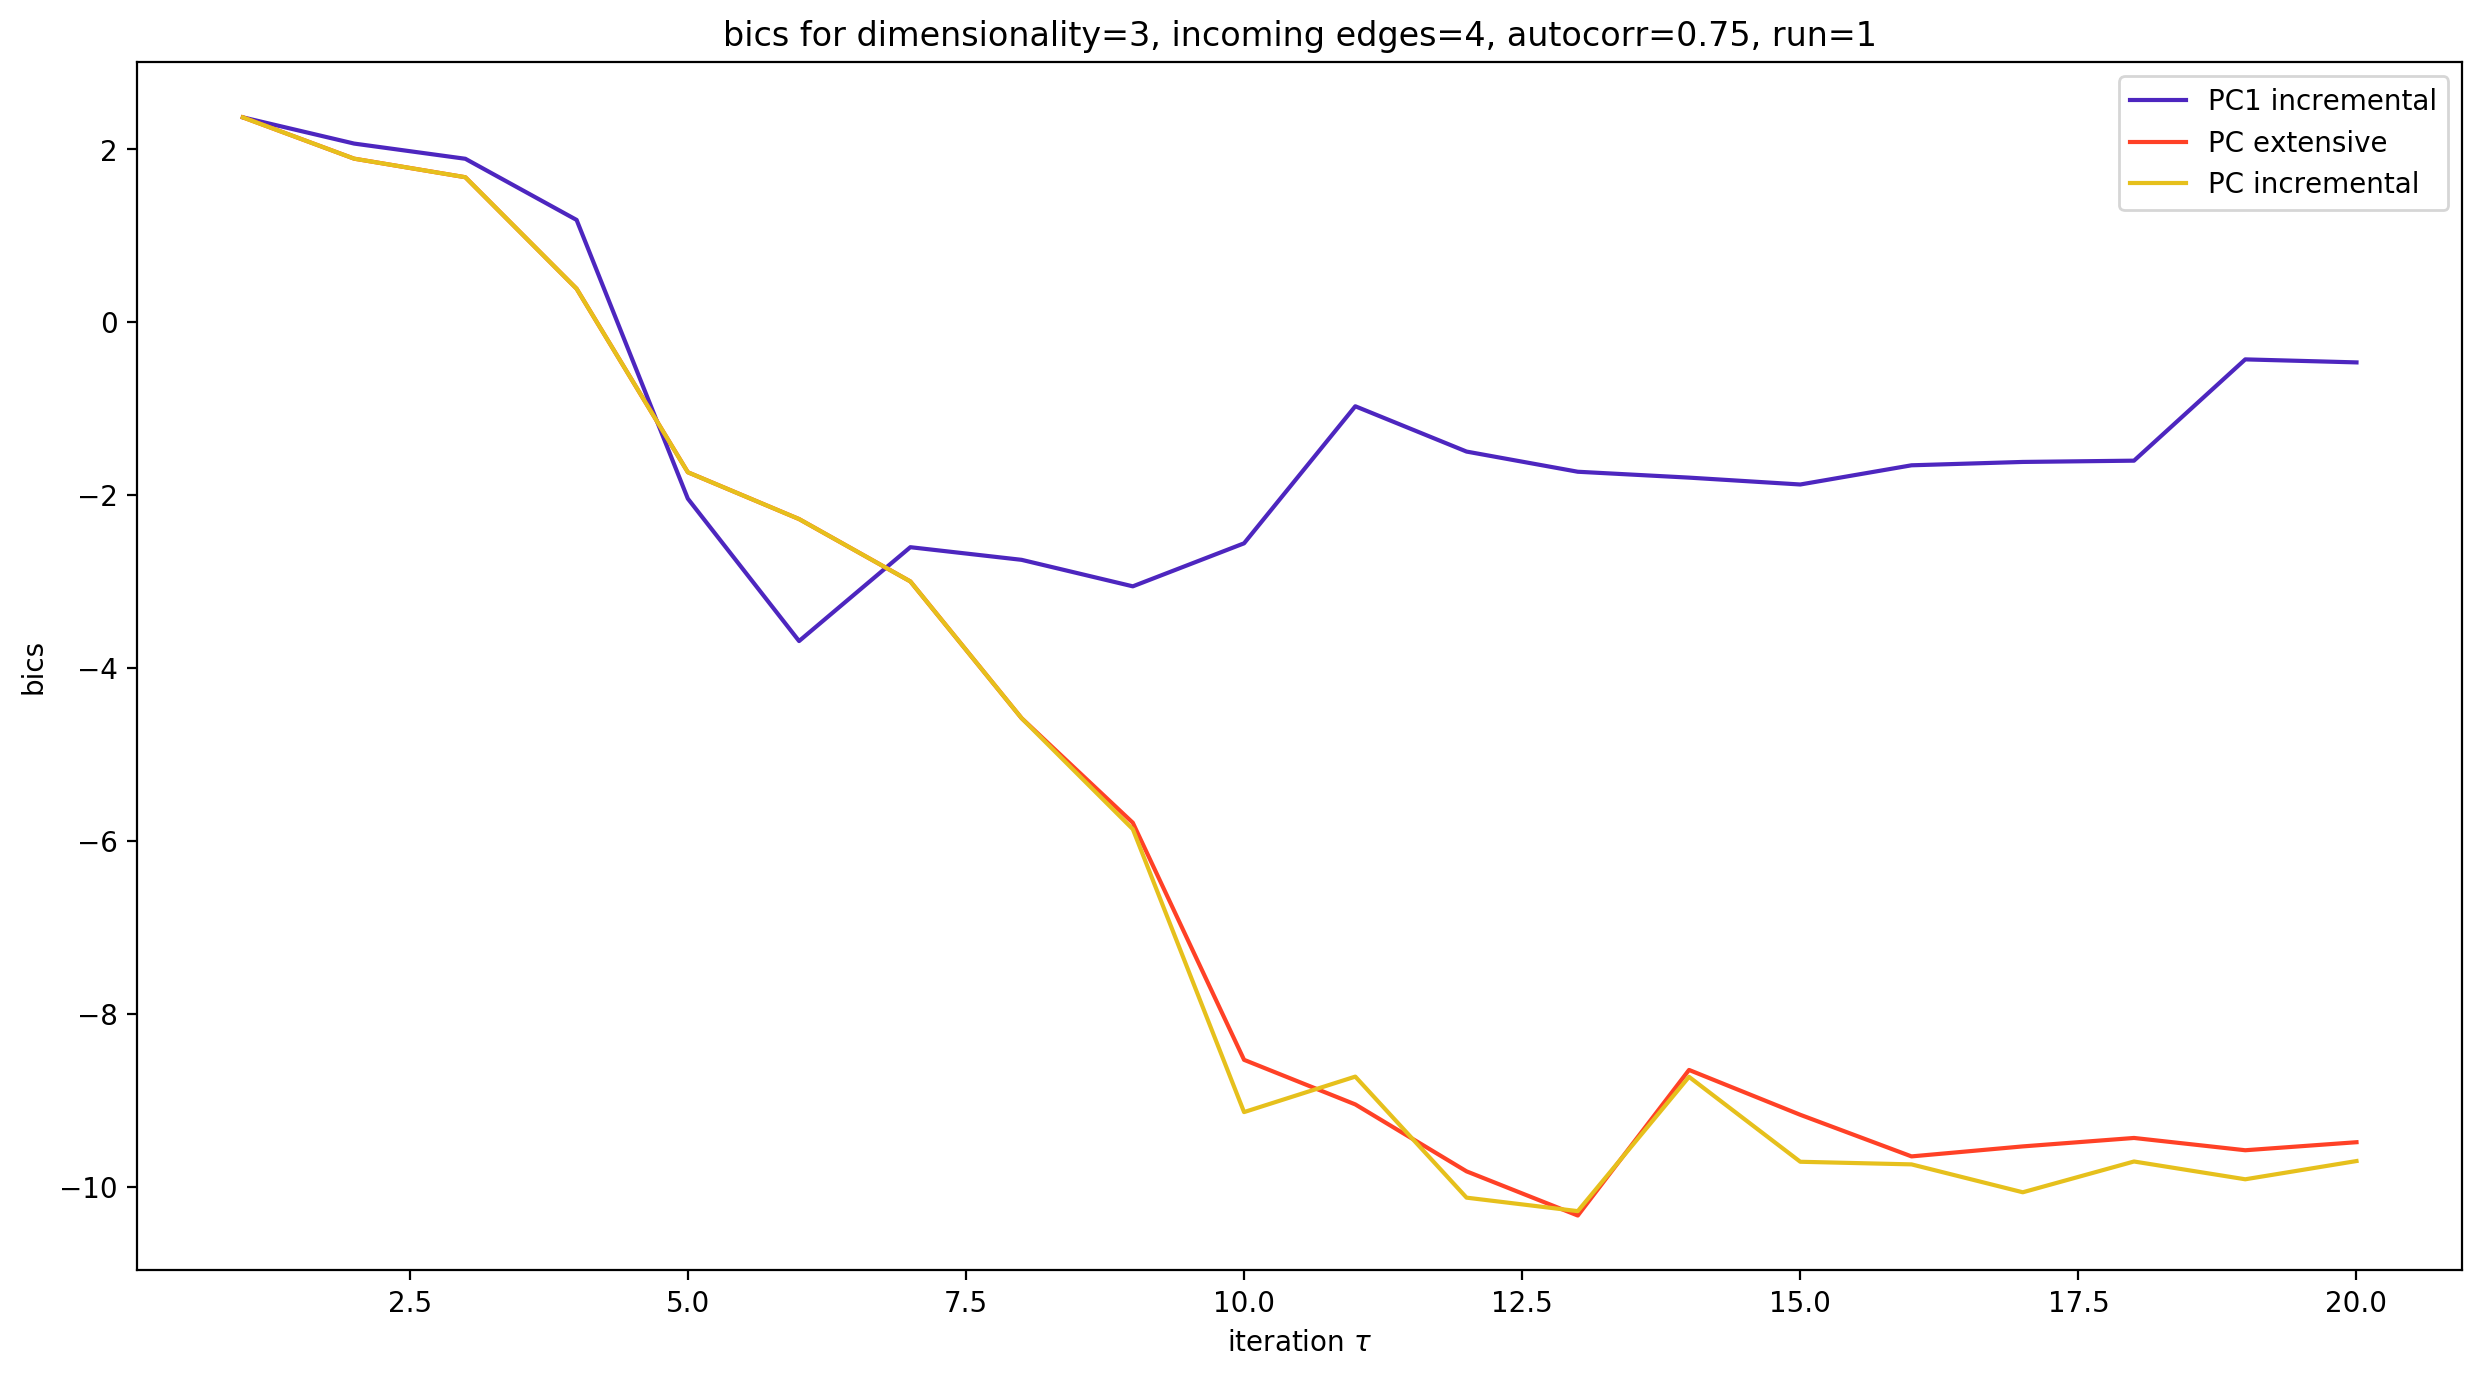

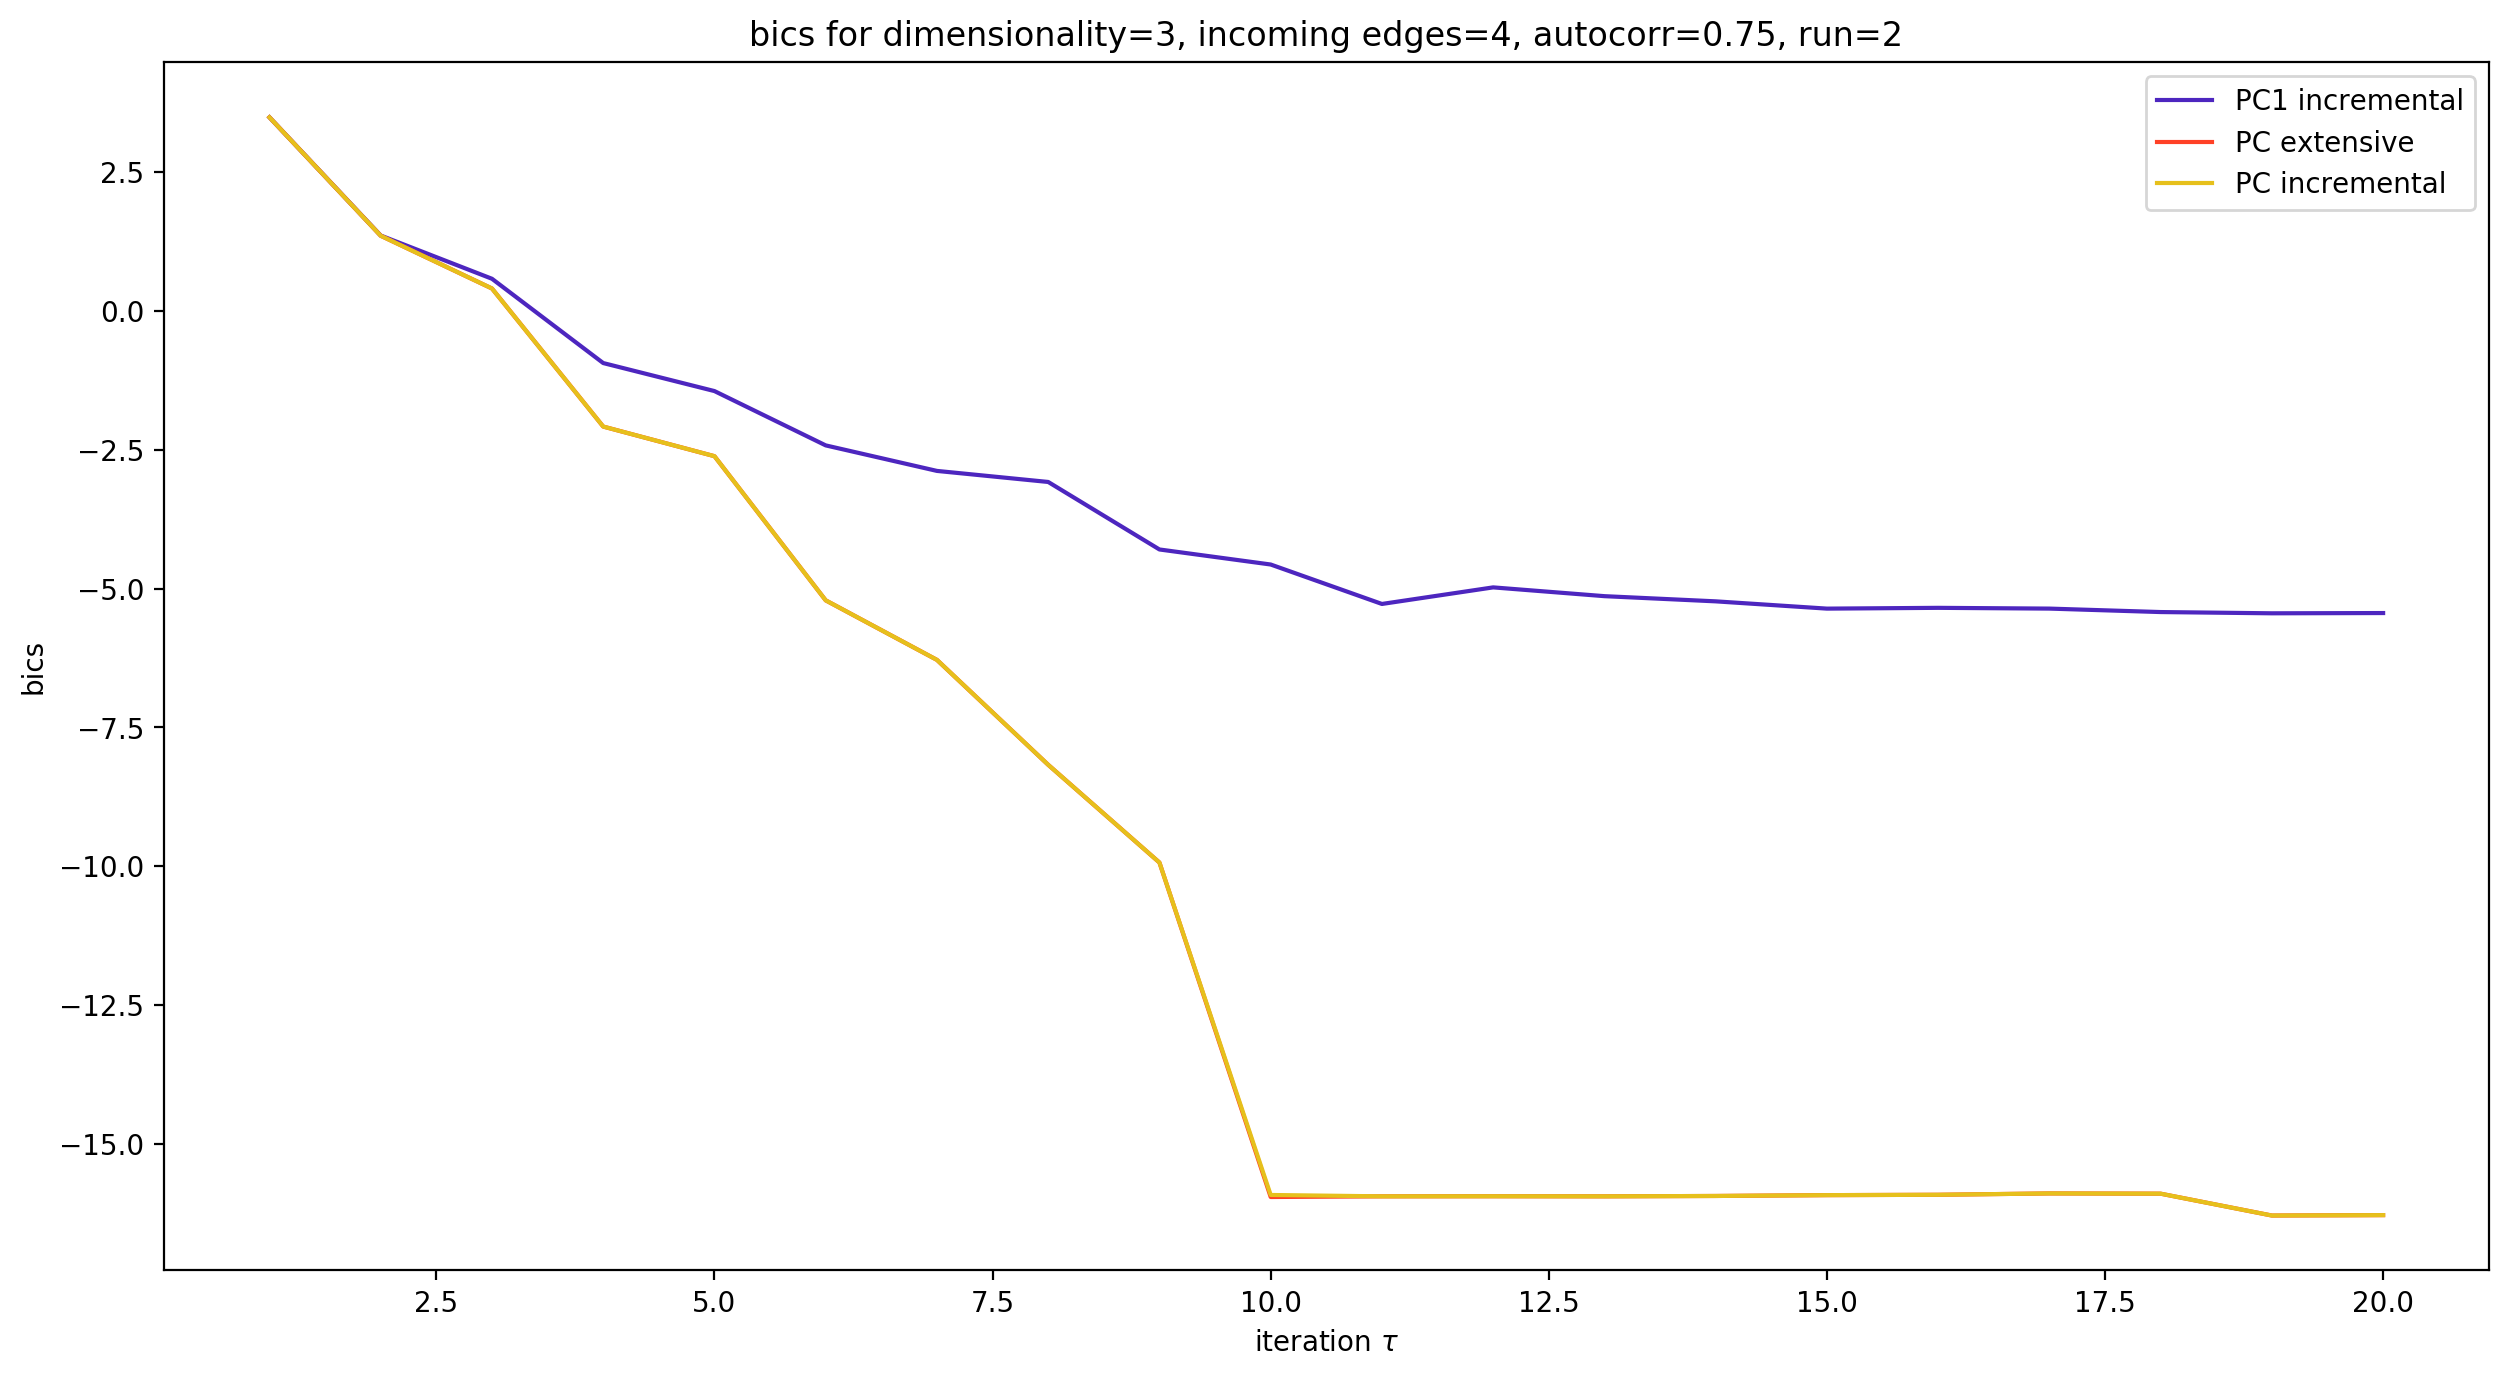

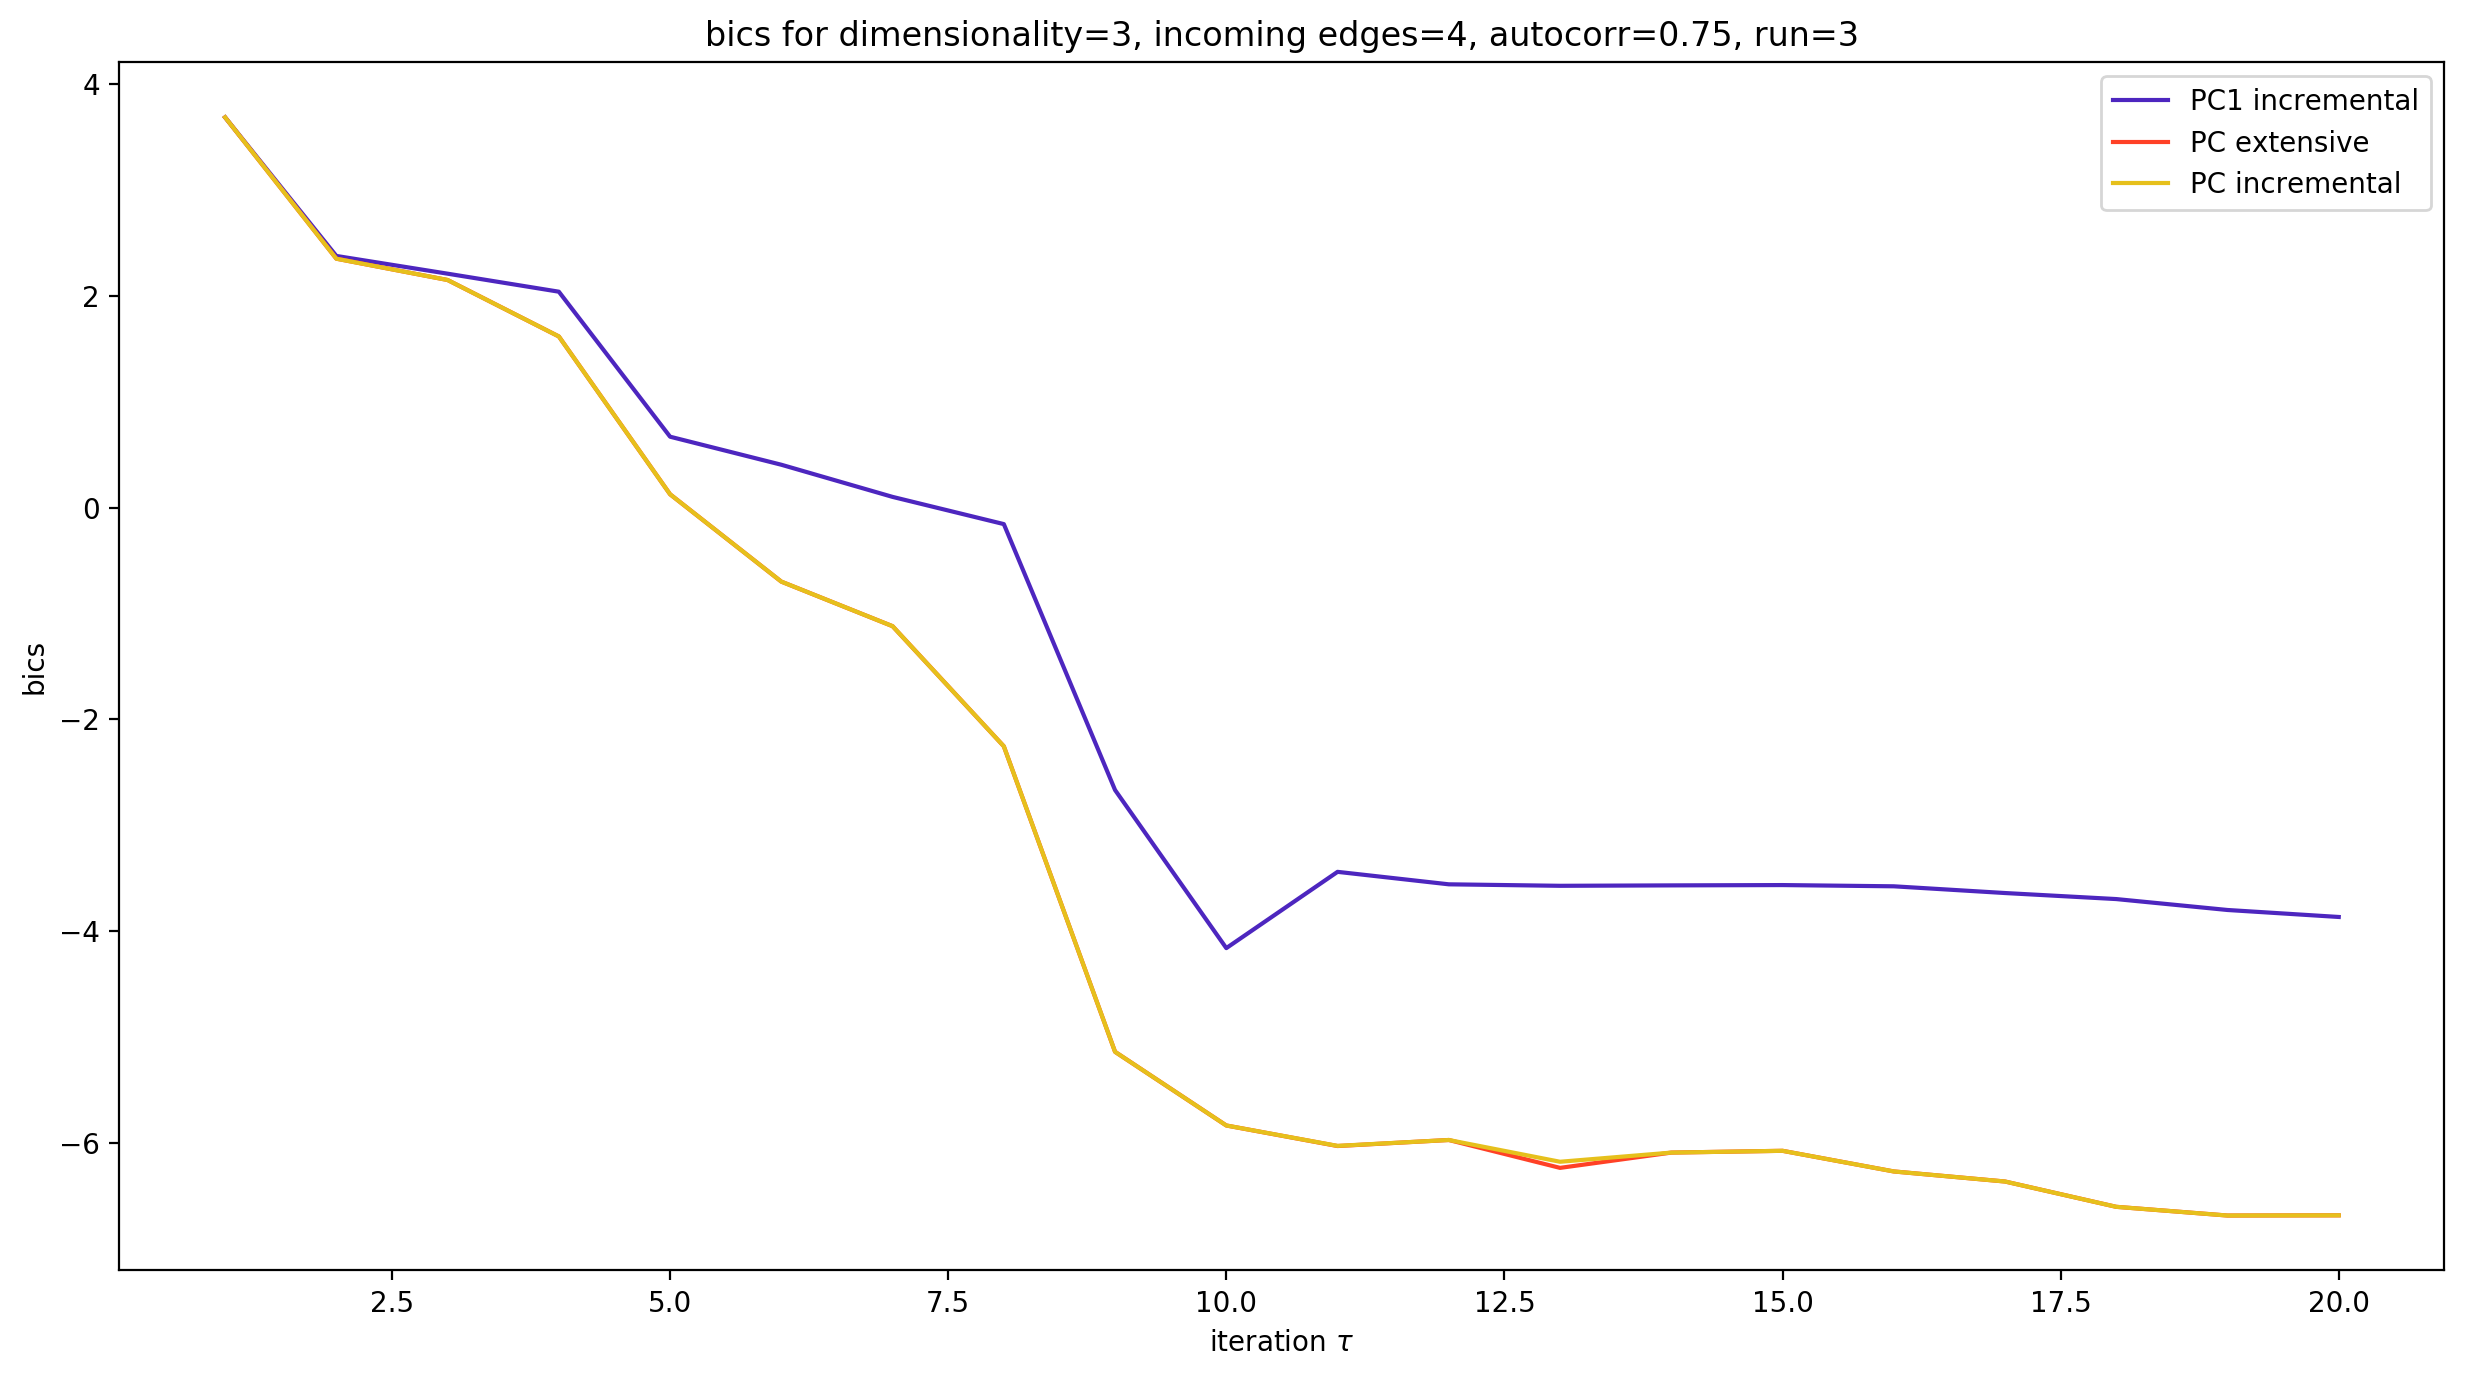

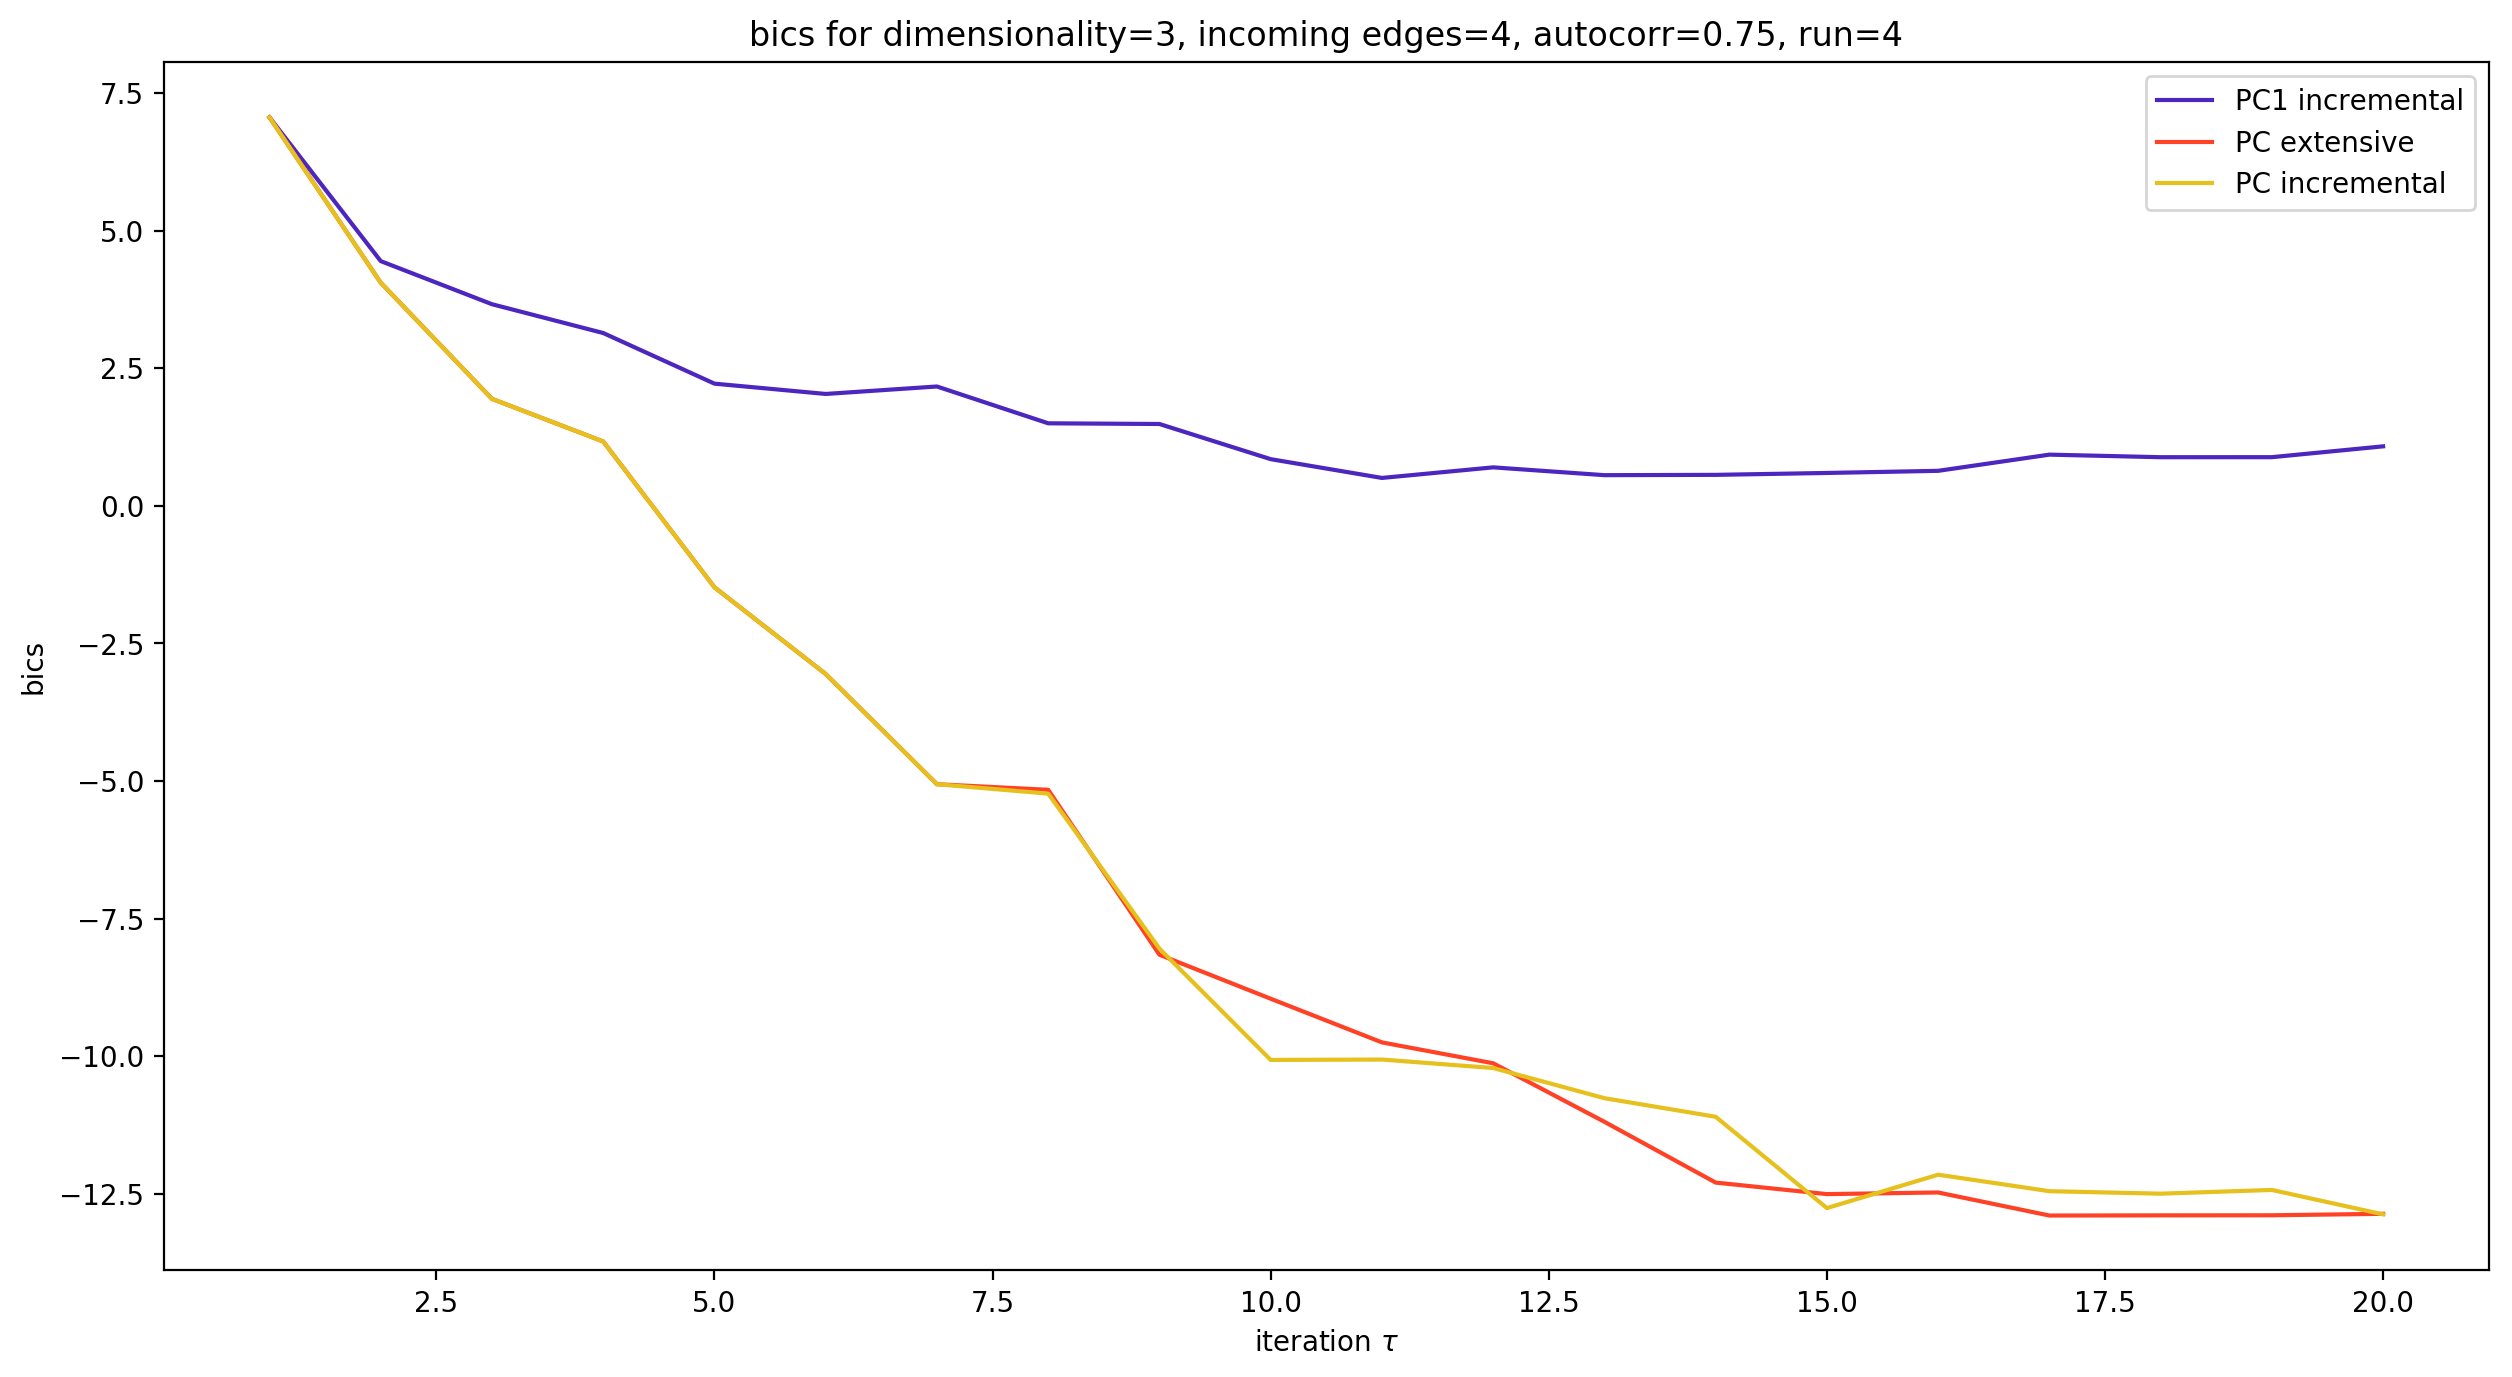

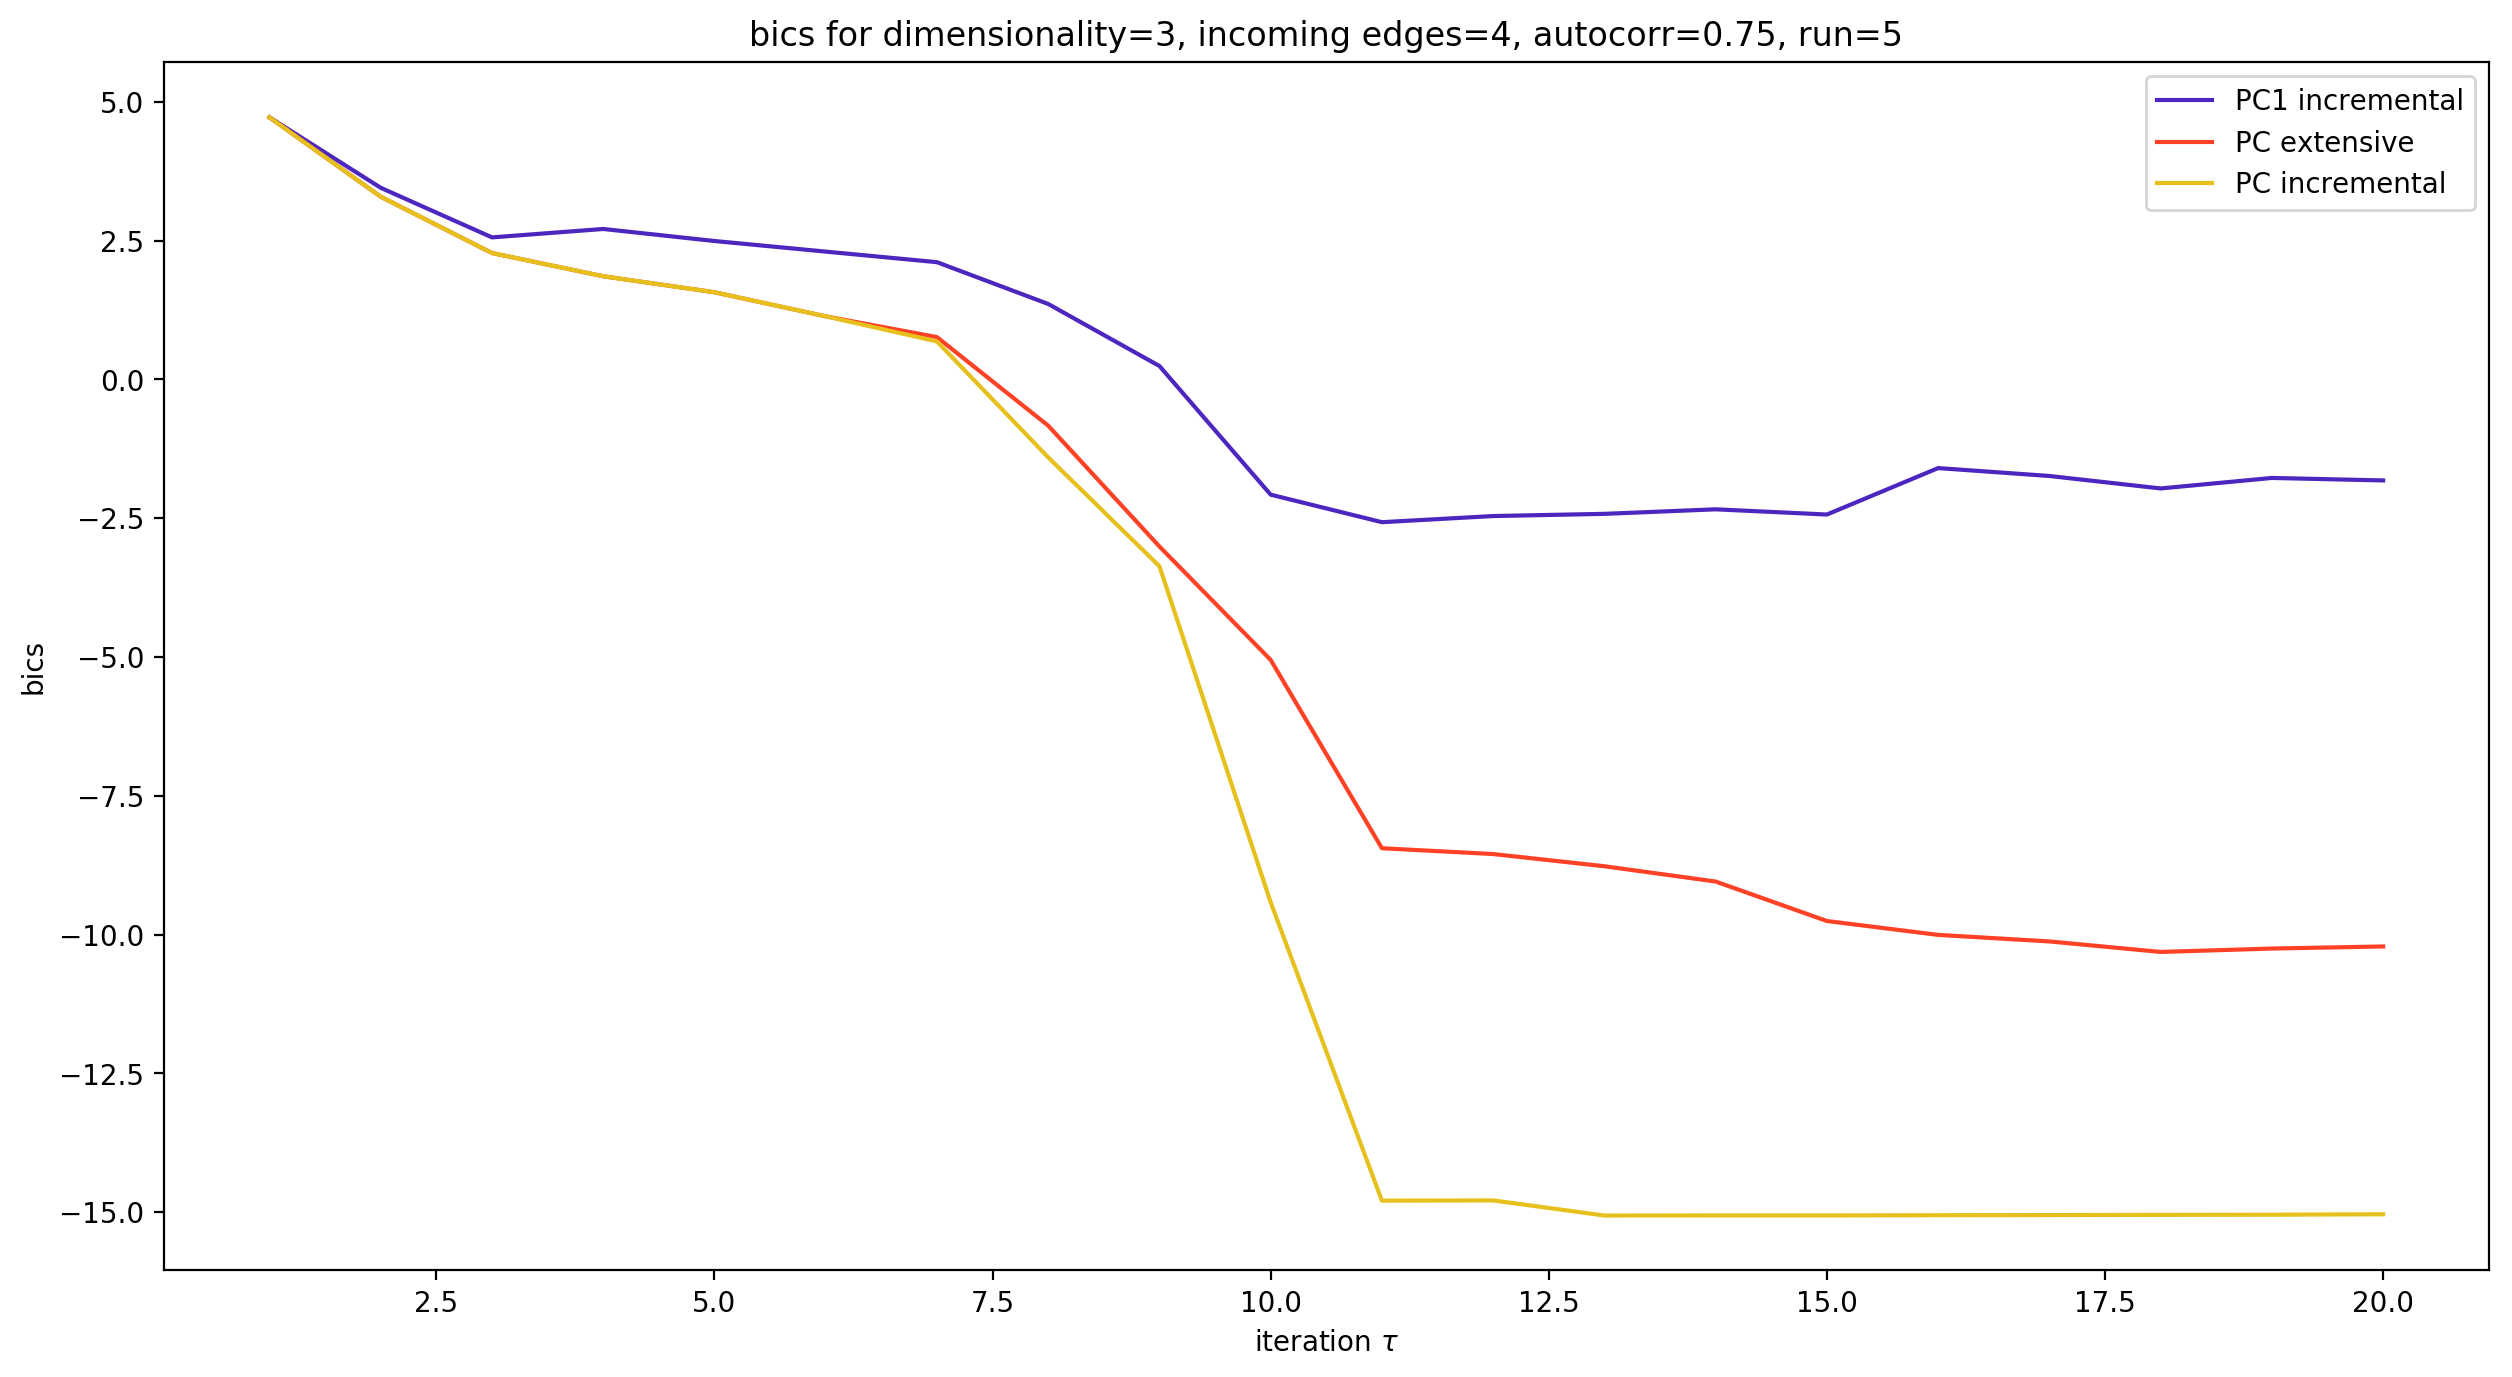

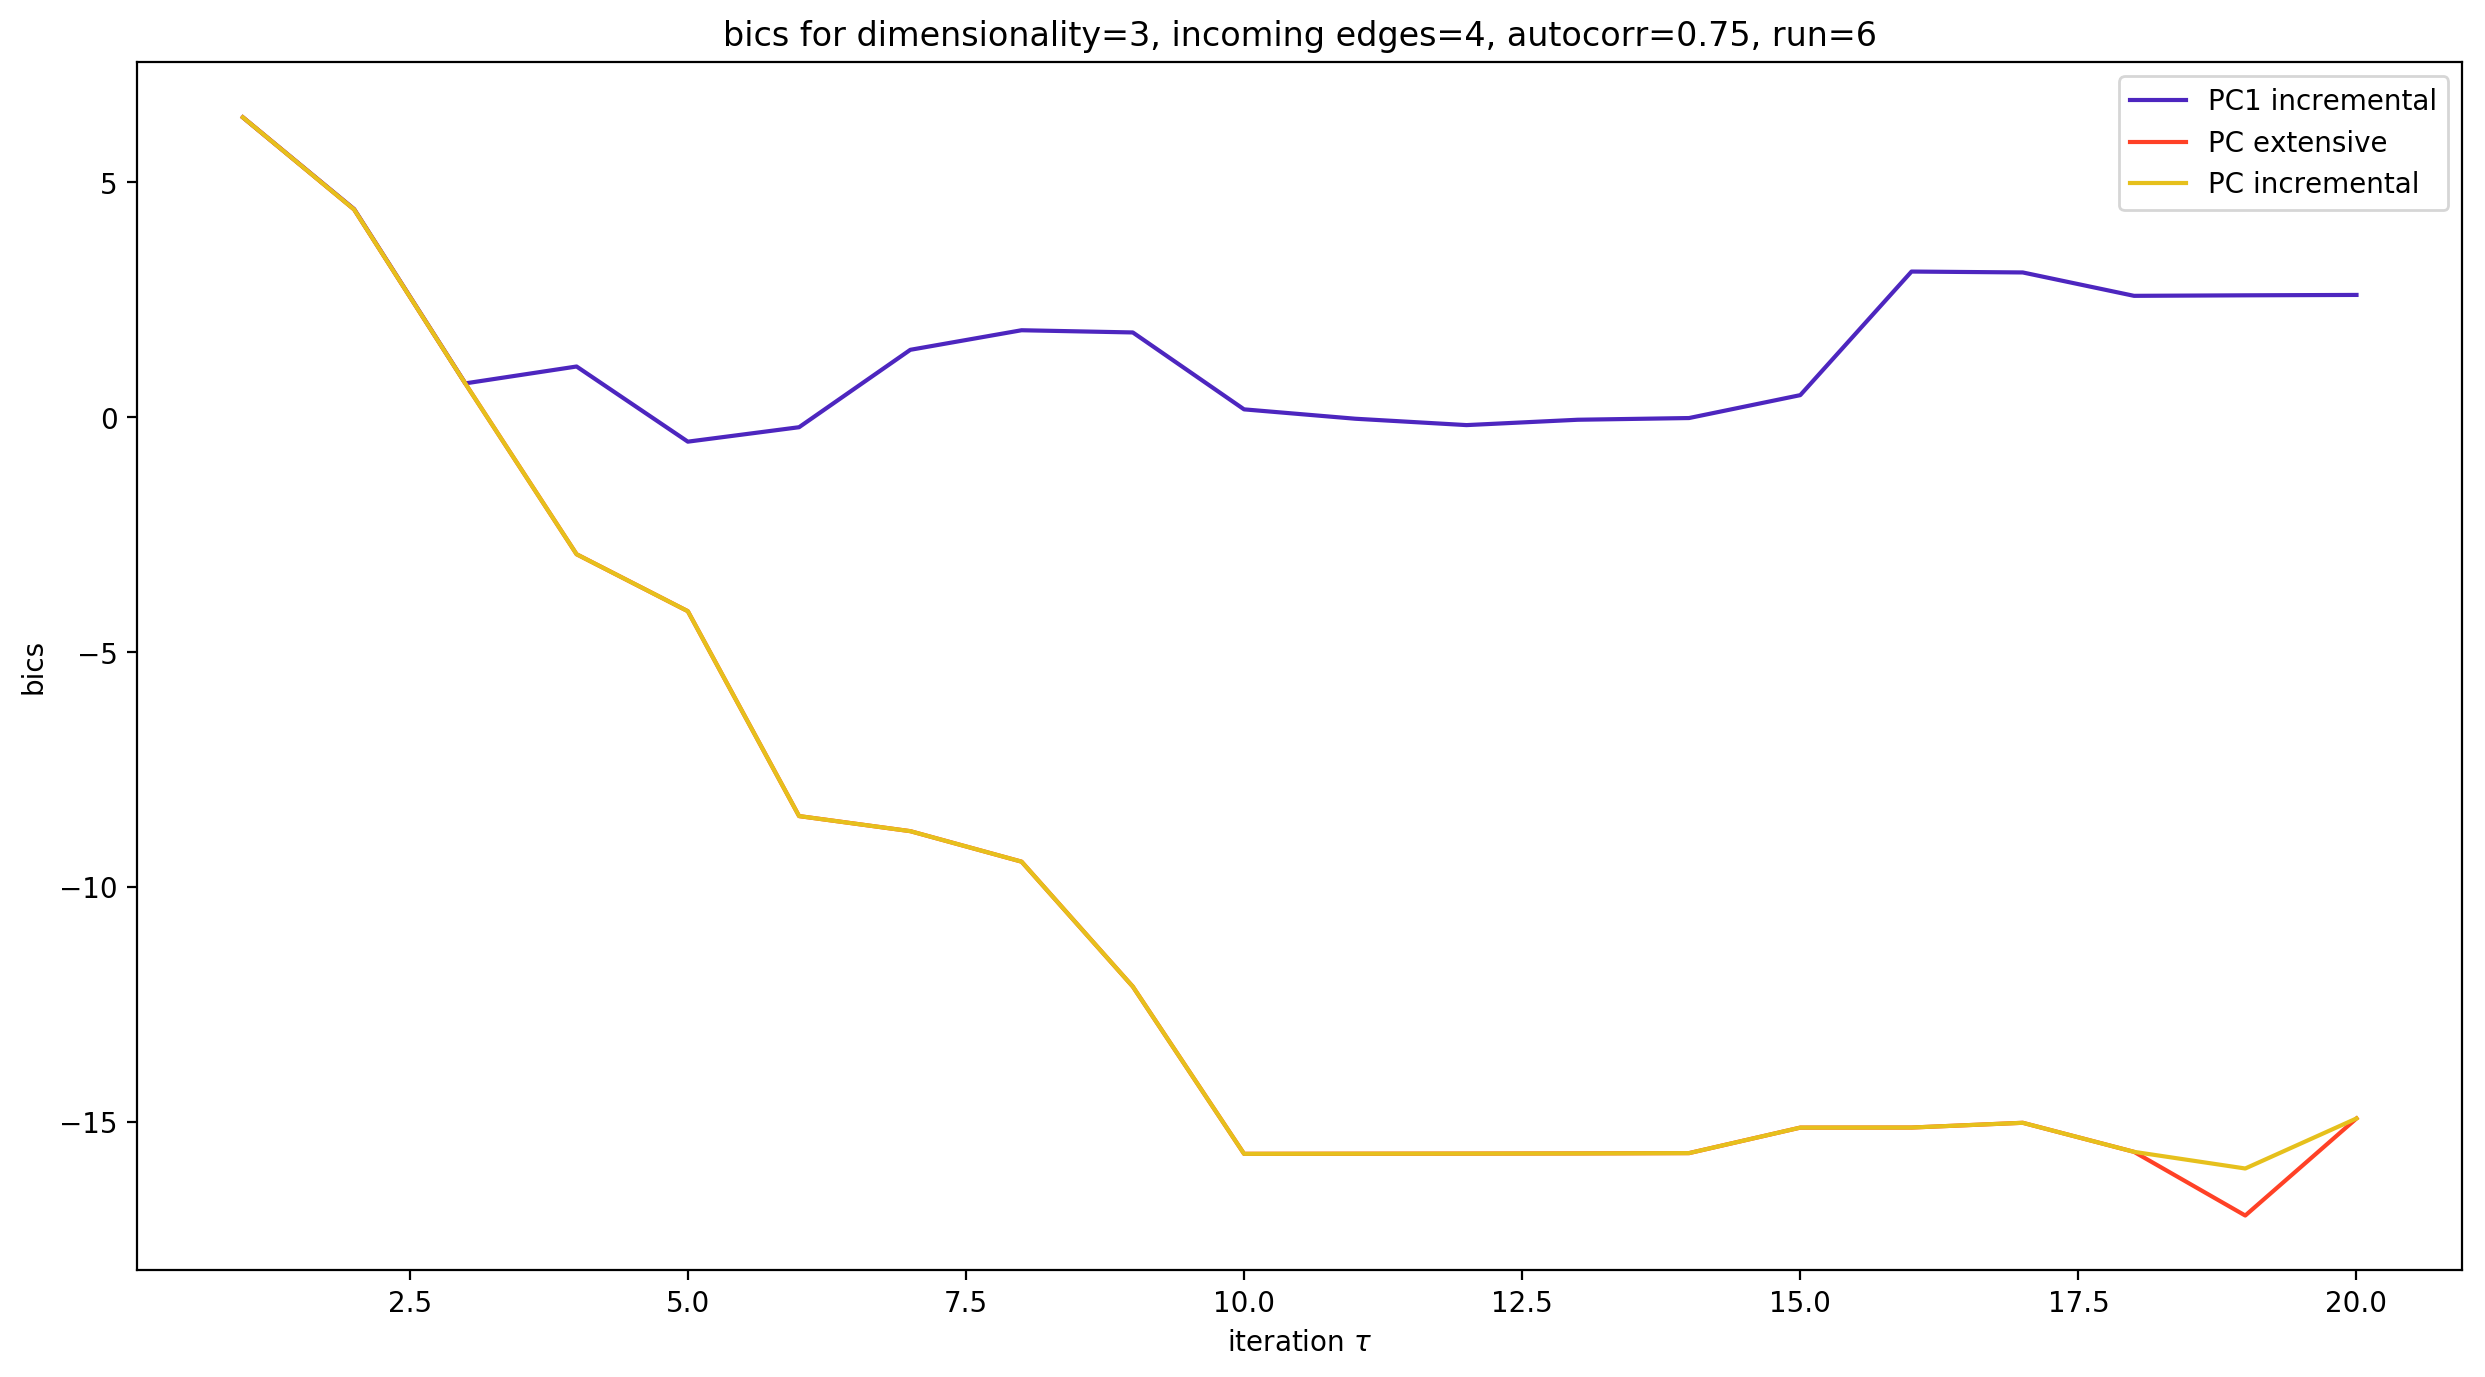

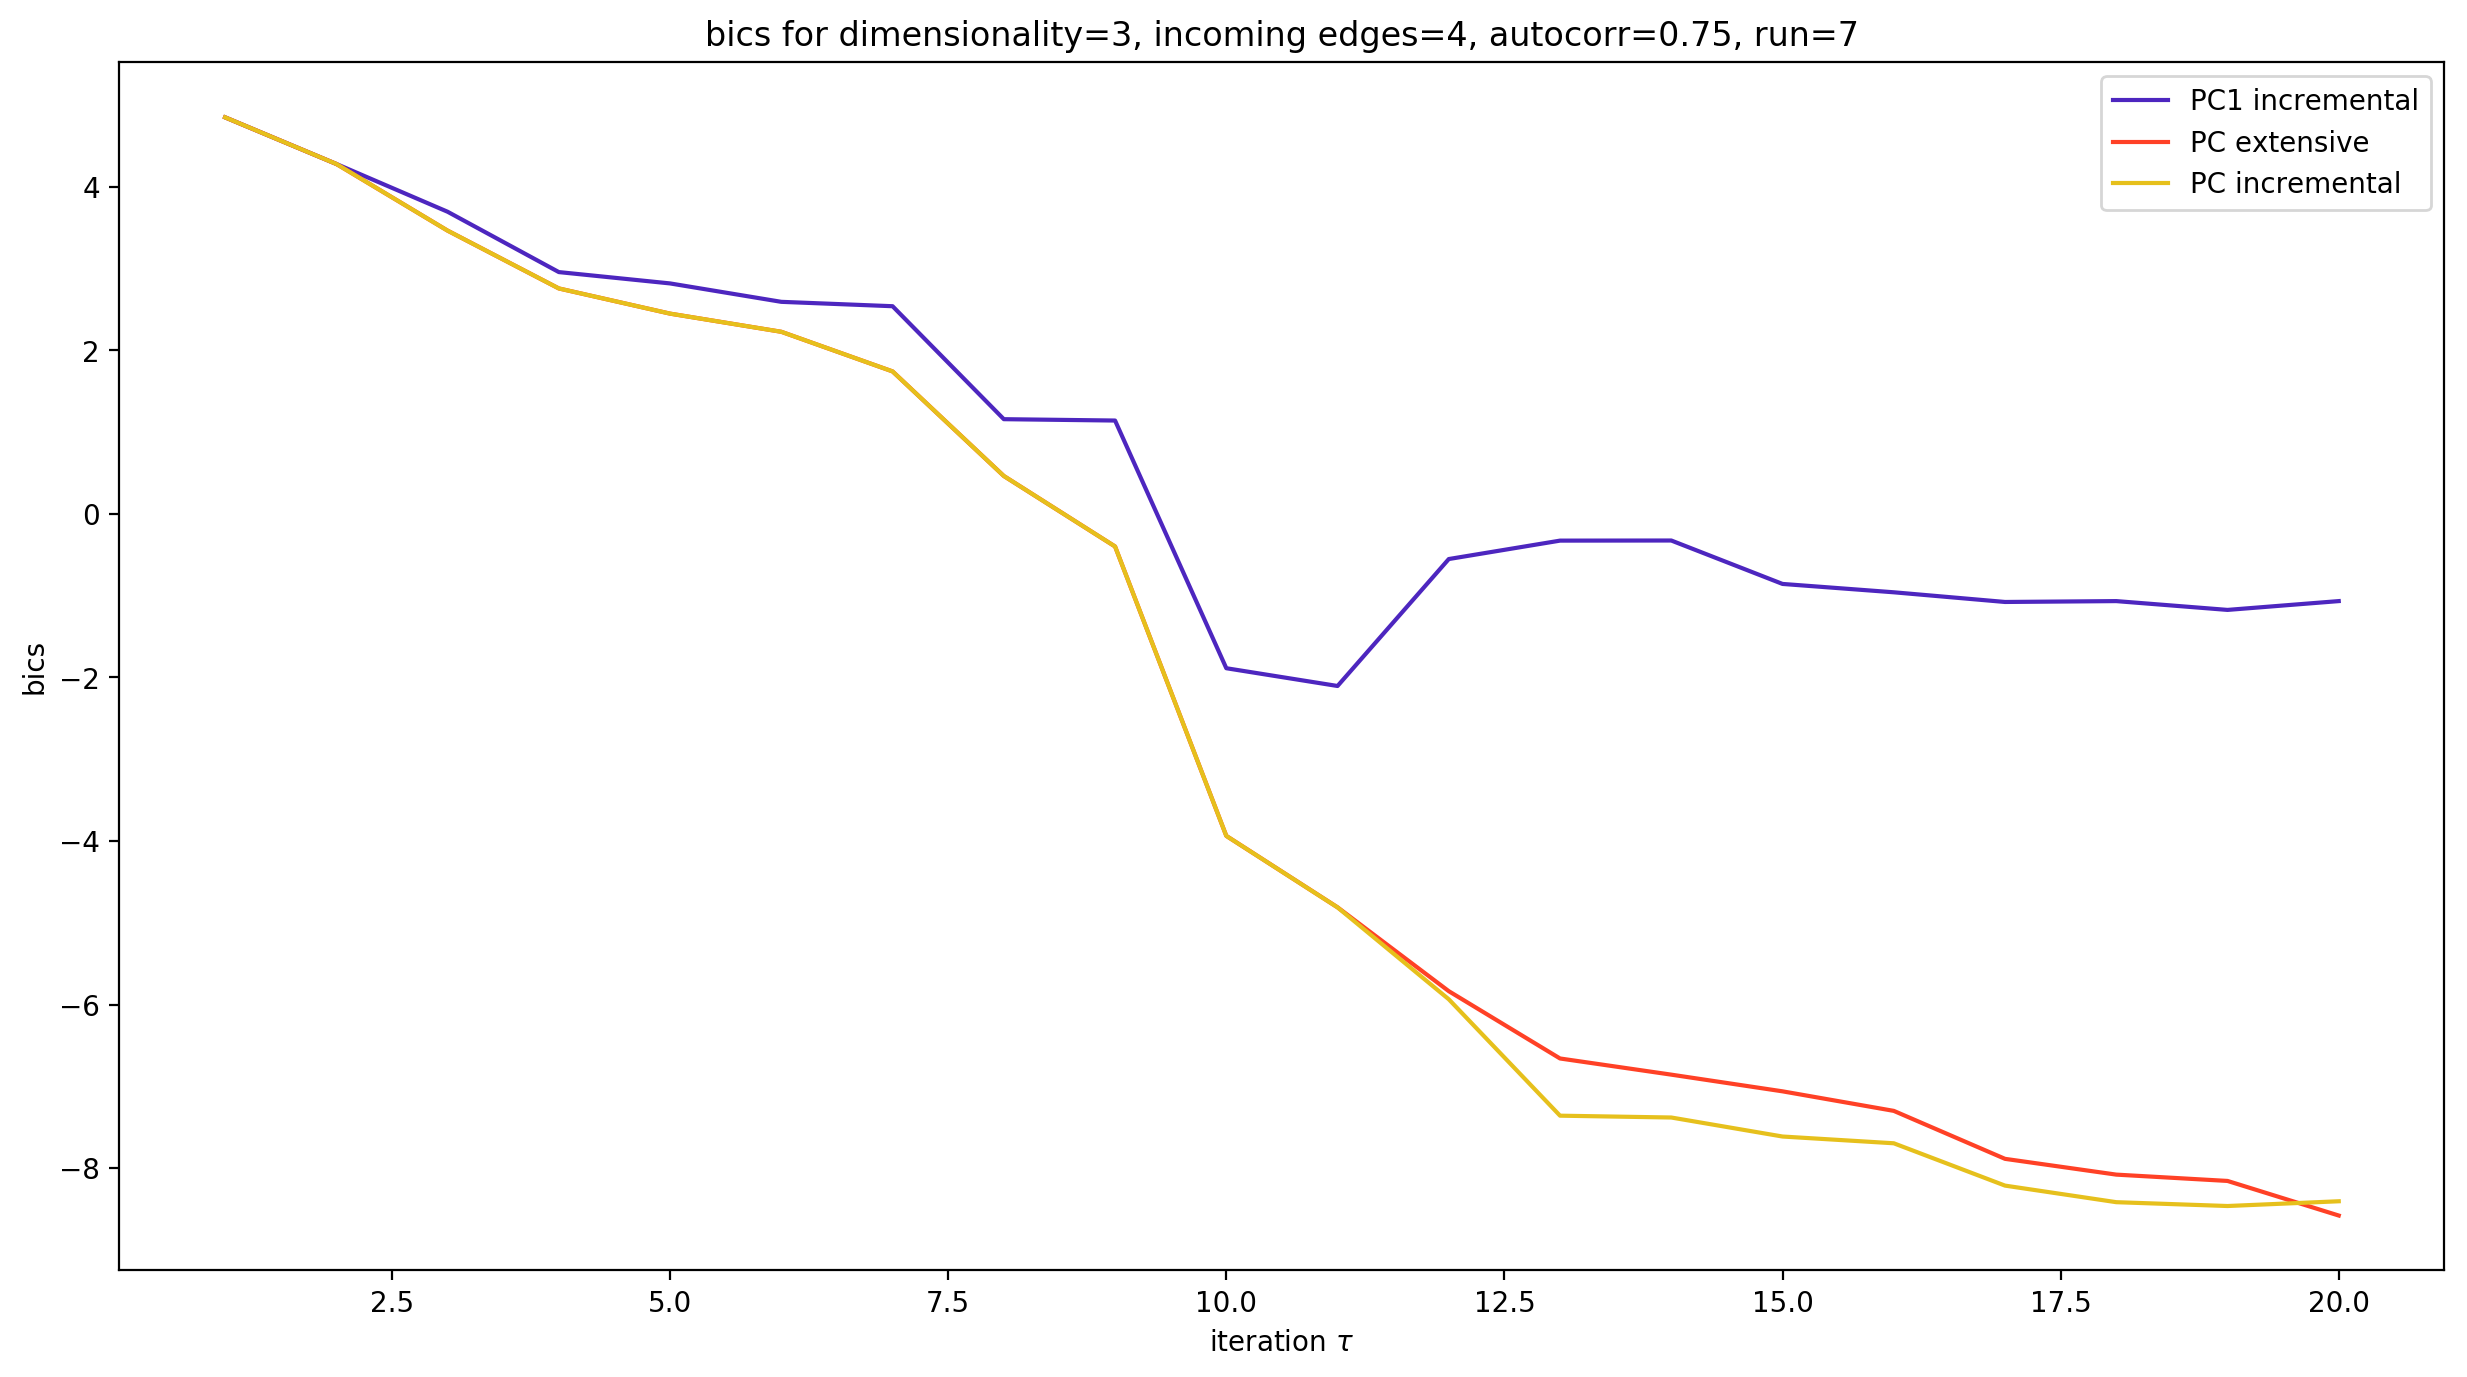

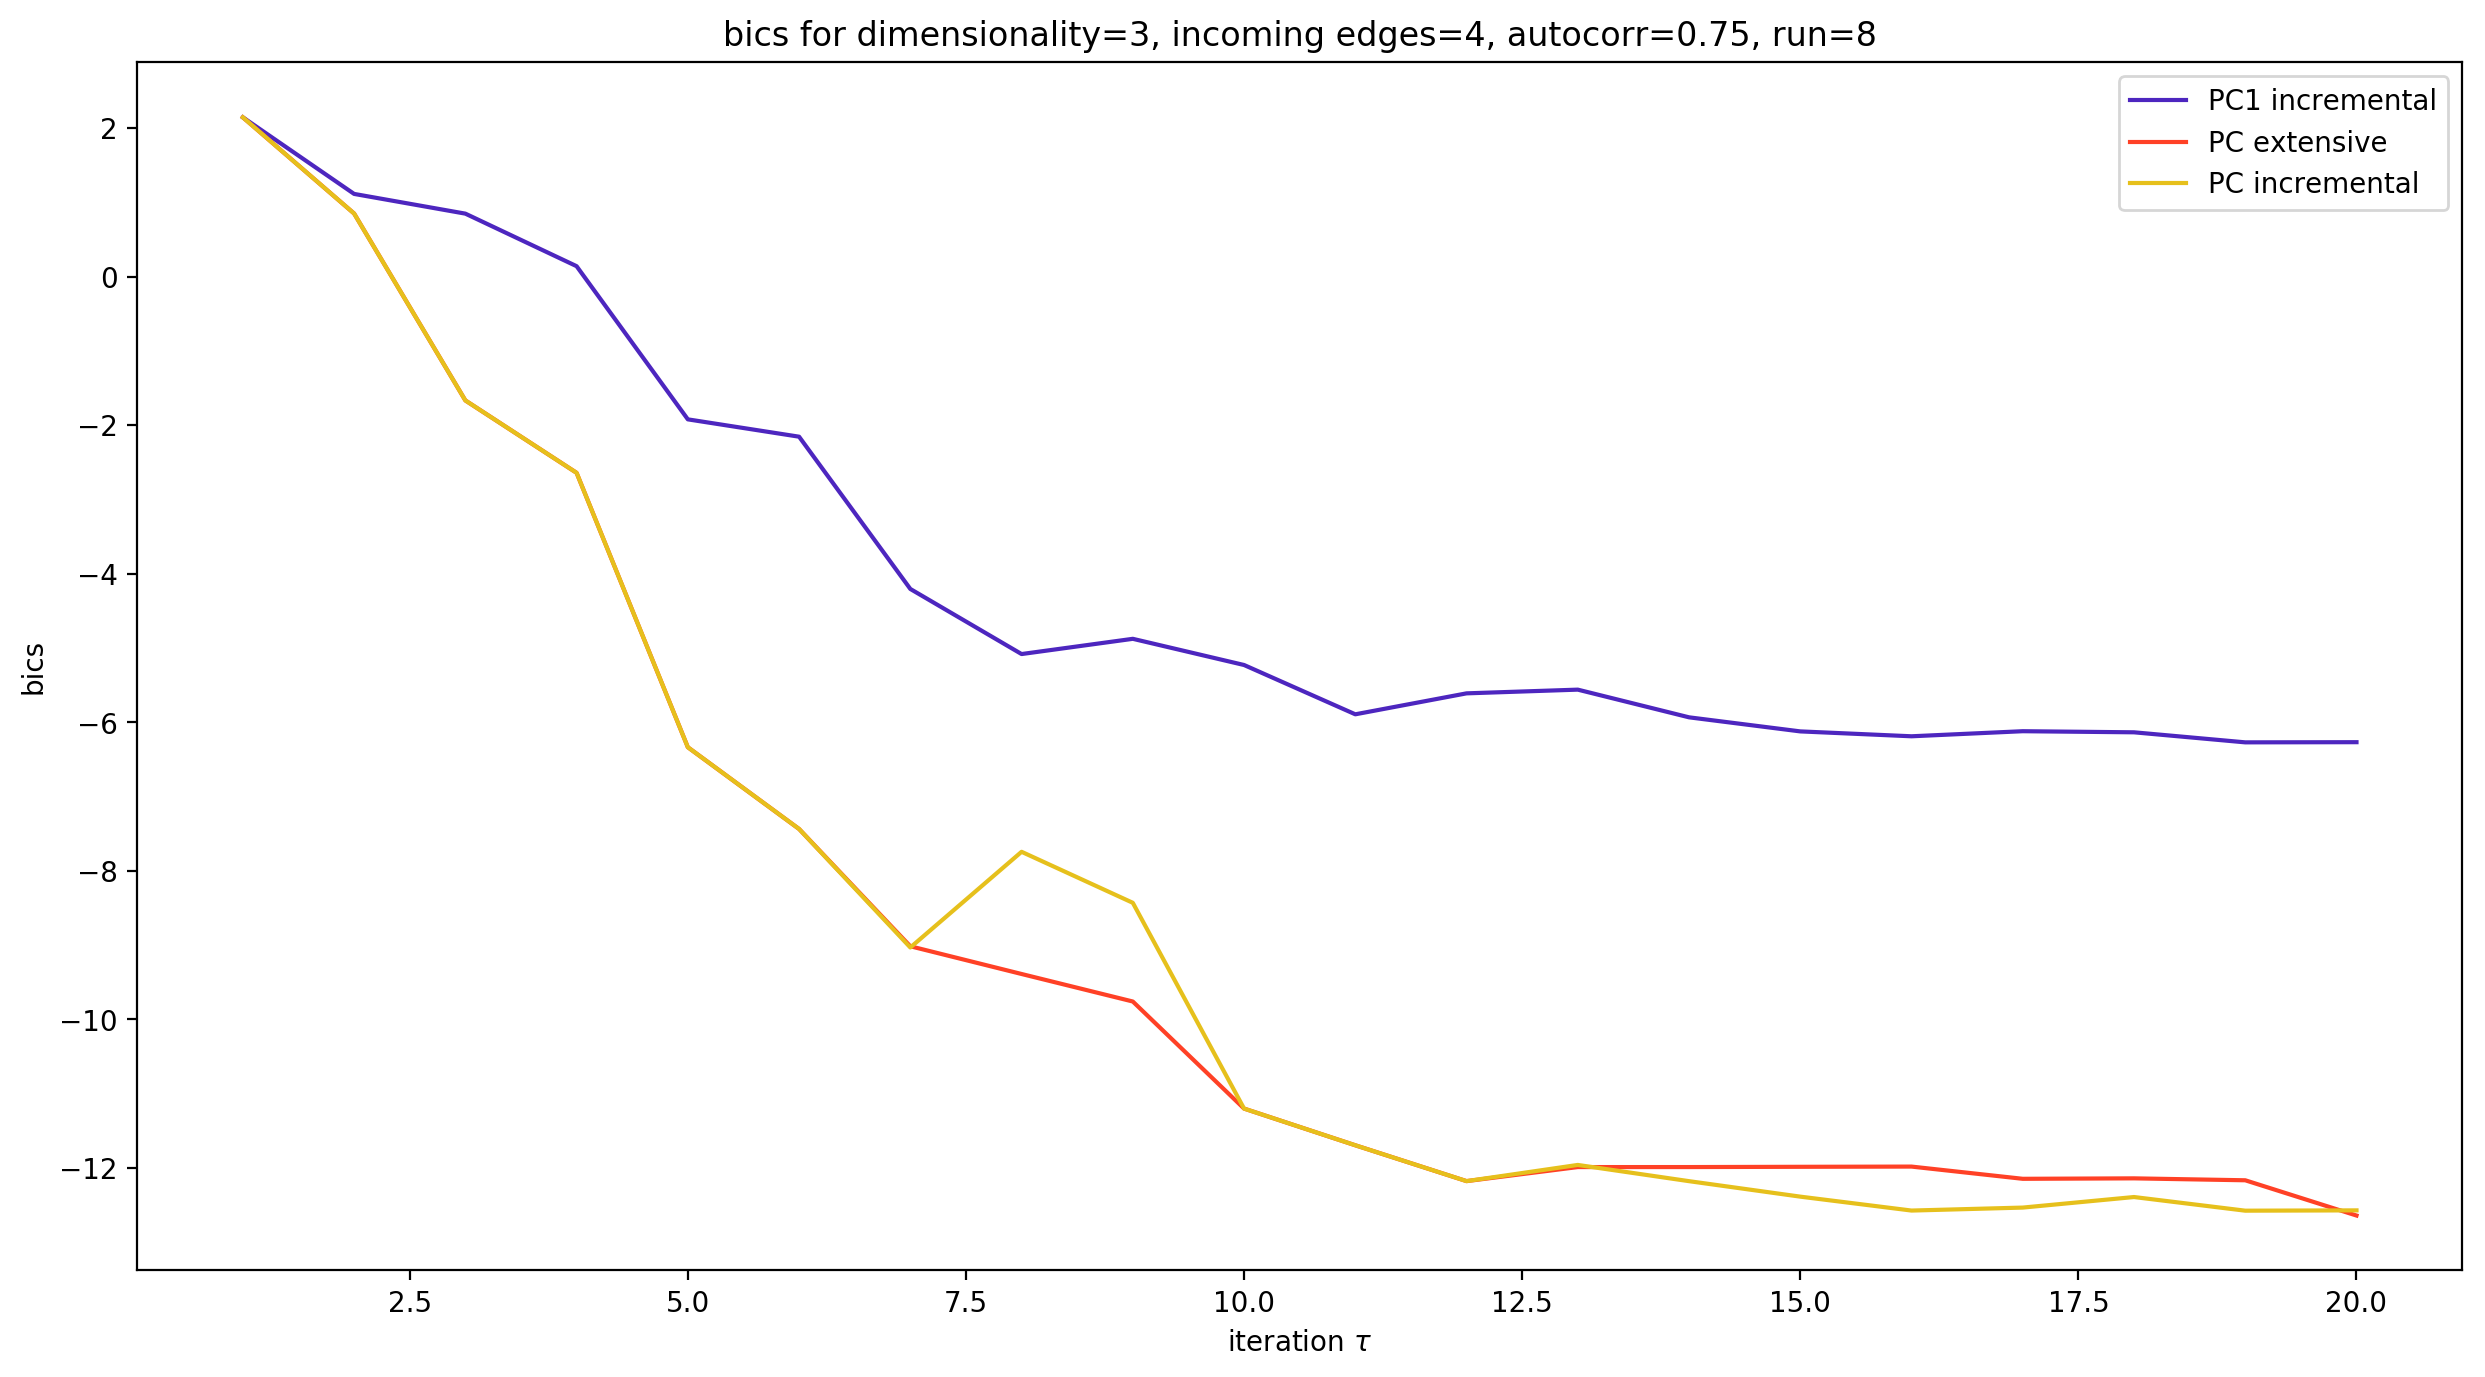

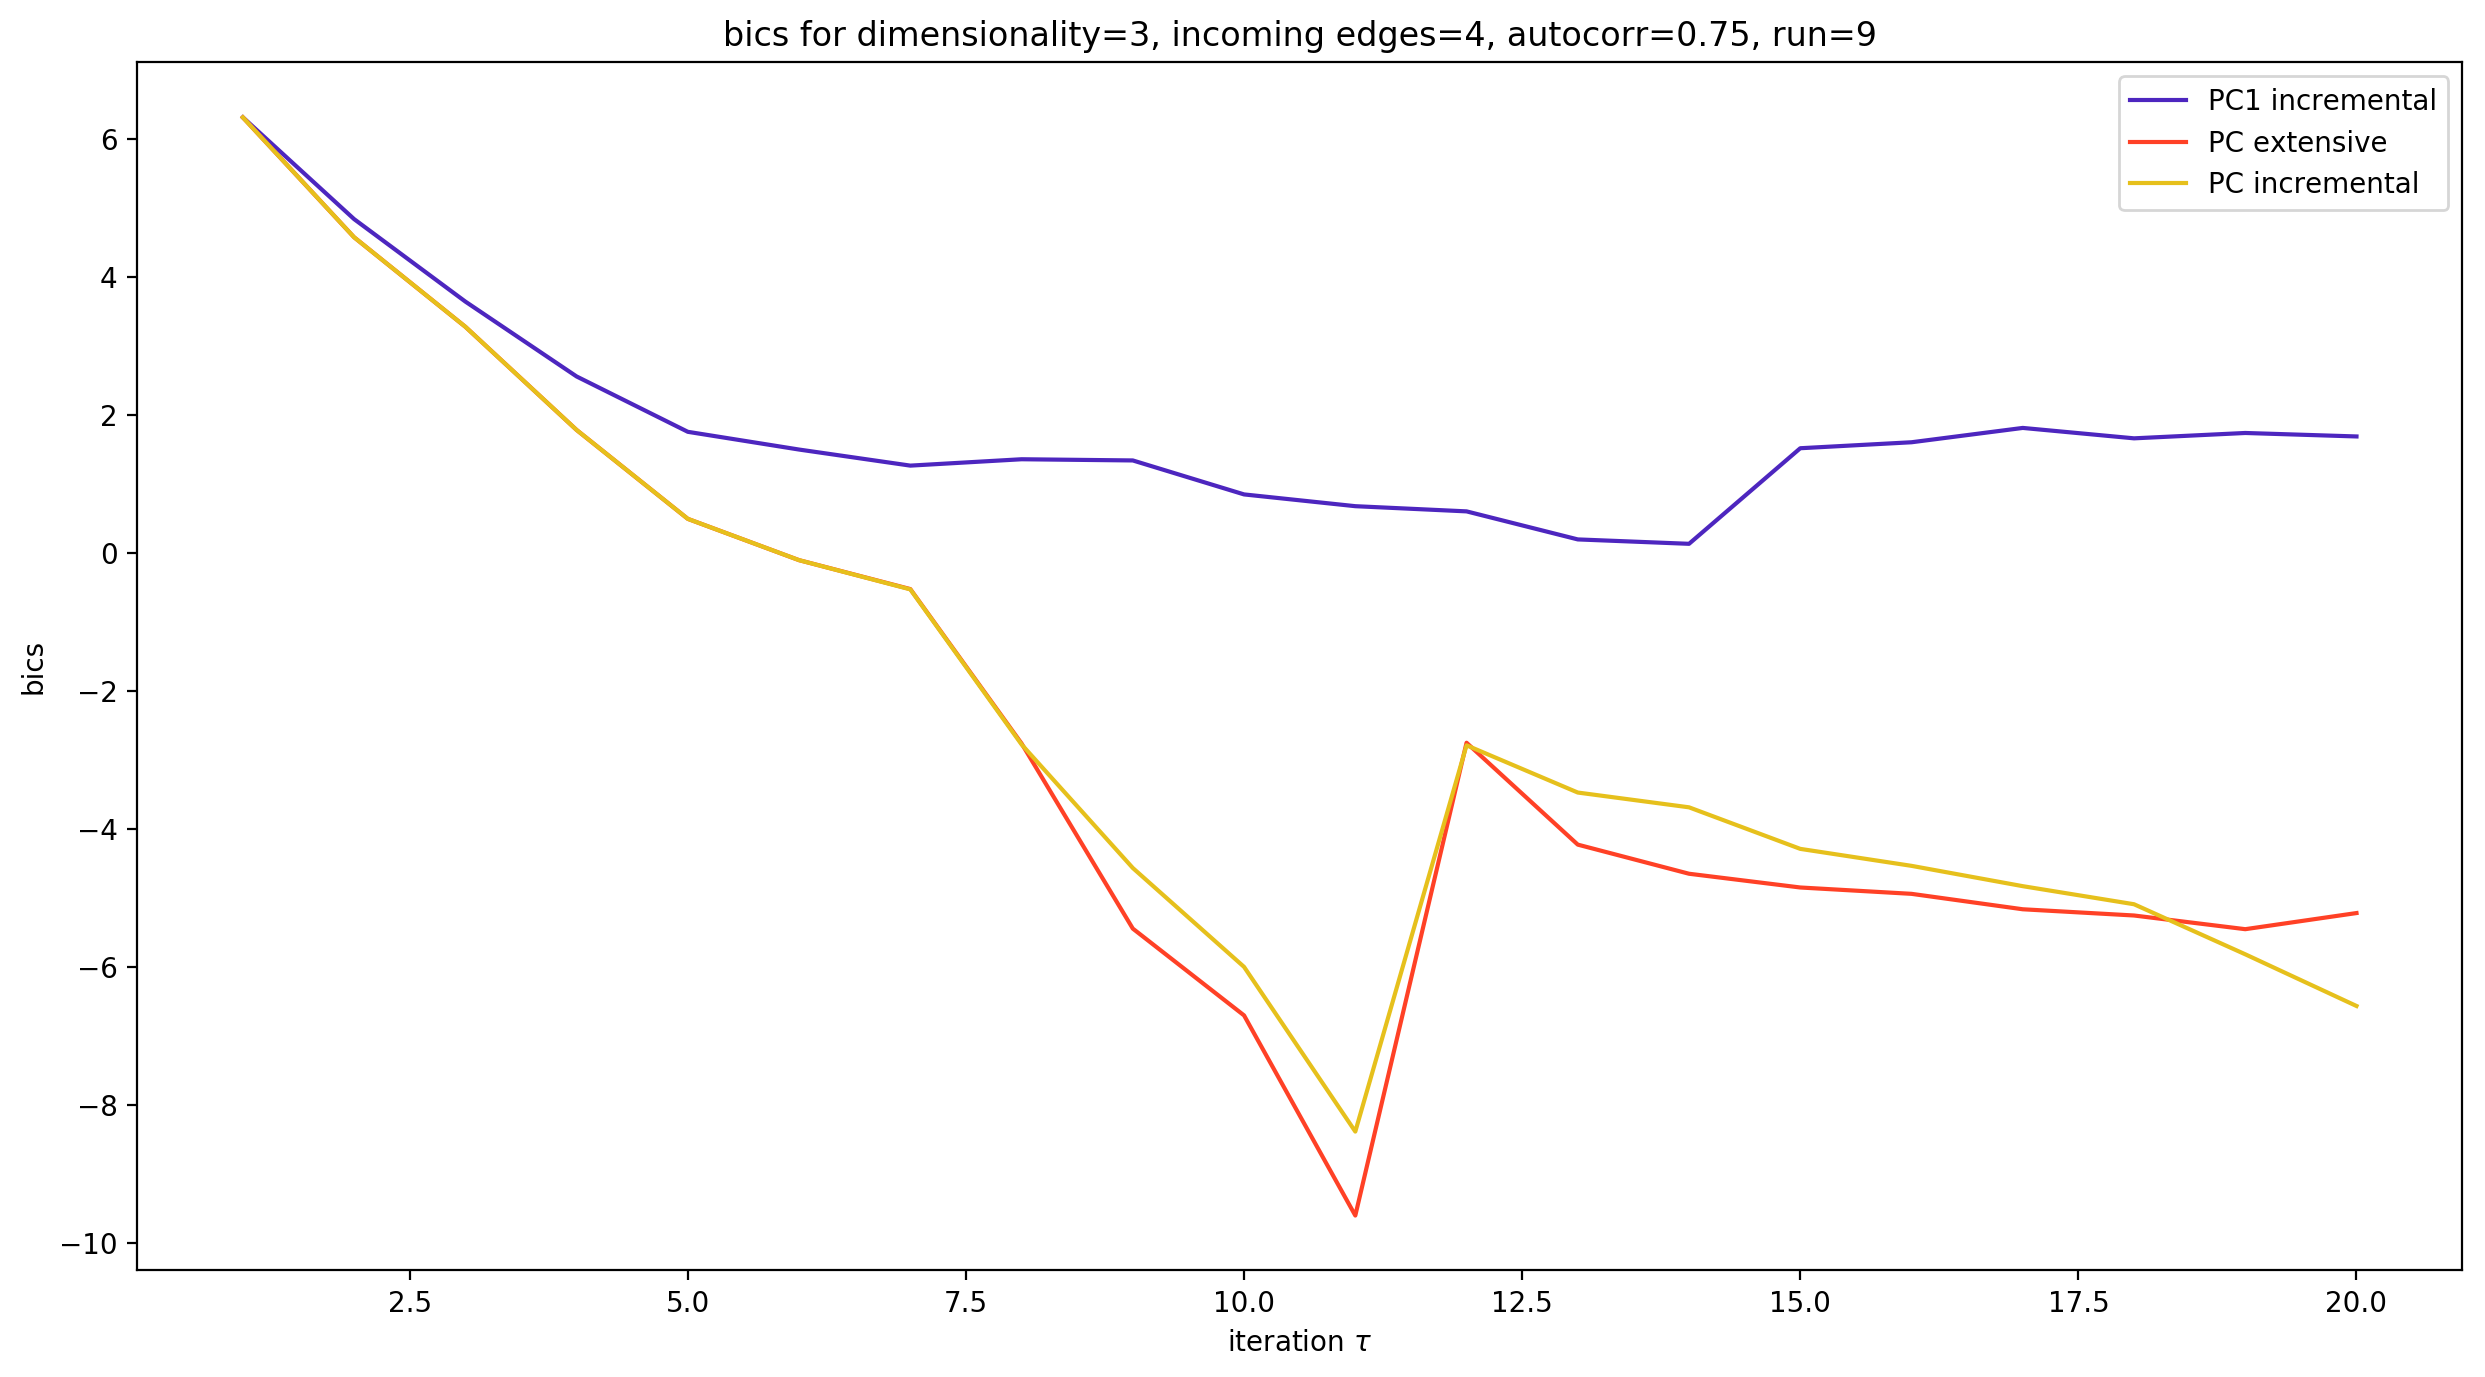

In [36]:
from math import floor

visualize = [(10, 3, 4, 0.75)]
names = ['PC1 incremental', 'PC extensive', 'PC incremental']
prop = 'bics'

width = 0.4
results_path = 'notebooks/ICML/icml_results/'

results = pd.read_csv(results_path + 'experiment3.csv')
true_taus = np.unique(results['max time lag'])

for group, result in results.groupby(['max time lag', 'dimension', 'incoming edges', 'autocorr', 'run']): 
    
    tau = int(group[0])
    dim = int(group[1])
    in_edges = int(group[2])
    autocorr = float(group[3])
    run = int(group[4])
    
    if (tau, dim, in_edges, autocorr) not in visualize:
        continue
    
    colors = plt.cm.CMRmap(np.linspace(0,1,len(names)+2))
    plt.figure(dpi=200, figsize=(15, 8))
    
    x = result['tau estimate']
    for i, name in enumerate(names):
        y = result[name + '_' + prop]
        plt.plot(x, y, color=colors[i+1], label=name)
    
    plt.xlabel('iteration $\\tau$')
    plt.ylabel(prop)
    plt.title(f'{prop} for dimensionality={dim}, incoming edges={in_edges}, autocorr={autocorr}, run={run}')
    
    plt.legend()
    plt.show()